In [1]:
import json, argparse, os
from turtle import width
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.widgets import Slider, TextBox
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
import matplotlib.animation as animation
from matplotlib import markers, rcParams
import numpy as np
import seaborn as sns

from scipy.optimize import curve_fit
def decsine(x,w,p,b,a):
    return a*np.exp(-b*x)*np.sin(x*w+p)

def decsine2(x,w,p,b,a,p2,a2):
    return a*np.exp(-b*x)*np.sin(x*w+p) + a2*np.exp(b*x)*np.sin(x*w+p2)

def B(w,ta,tc,ab):
    return np.sqrt((1j*w)/(1+(ab/((1+(1j*w*ta))*(1+(1j*w*tc))))))

plt.style.use("./tplot.mplstyle")

In [5]:
#abi=np.array([9.7,10.0])
abi=np.array([10])
t2=20.0
t3=50.0
b=1.0
a=10.0
l=1
dt=0.1
tf=10050.1
times= np.arange(0, tf, dt)
omega0s = np.arange(0.01, 0.27, 0.01)
omega0s = np.append(omega0s,np.arange(0.3,1,0.1))
omega0s = np.append(omega0s, [ 0.003, 0.005, 0.007, 0.009])
#Ni = np.array([49,50,51,60,75,80,100])
Ni = np.array([100, 120, 150])
#omega0s = np.append(omega0s, np.arange(0.049,0.064,0.002))
omega0s = np.sort(omega0s)
plensm=[]
Bufields=[]
popt=np.array([ 0.01622445,  1.76165405,  0.01219741, -0.12036567])	#initial guess for parameters

for ab in abi:
	for N in Ni:
		print(ab,N)
		
		Sols=[]

		for omega0 in omega0s:
			if omega0<0.01:
				Sols.append(np.fromfile("osc_strain_0.5_disp/{:d}/{:1.1f}/{:1.1f}/{:1.1f}/solution_{:1.3f}.dat".format(N, ab, t2, t3, omega0)))
			else:
				Sols.append(np.fromfile("osc_strain_0.5_disp/{:d}/{:1.1f}/{:1.1f}/{:1.1f}/solution_{:1.2f}.dat".format(N, ab, t2, t3, omega0)))
			Sols[-1]=Sols[-1].reshape(len(times), 3*N+1)

		Sols = np.asarray(Sols)
		#to find displacement, subtract each r_i from its original position
		ufields = Sols[:,5000:,:N+1]-np.arange(0,N+1,1)[np.newaxis,np.newaxis,:] #subtract each r_i from its initial position
		ufields -= np.mean(ufields, axis=1)[:,np.newaxis,:]
		fftufields = np.fft.rfft(ufields, axis=1)
		qs = np.fft.rfftfreq(len(ufields[0,:,0]), dt)
		fftmags = np.abs(fftufields)
		fftBufields = np.zeros_like(fftufields)

		for i in np.arange(len(omega0s)):
			index = np.where(qs*2*np.pi//omega0s[i]==1)[0][0]
			fftBufields[i,index,:]+=fftufields[i,index,:]
			#plt.plot(qs*2*np.pi, abs(fftBufields[i,:,1]))
		#plt.show()
		Bufield = np.fft.irfft(fftBufields, axis=1)
		plens = np.zeros(len(omega0s))
		bs = np.zeros((len(omega0s),50))
		for i in np.arange(0,len(omega0s),1):
			for t in np.arange(50):
				popt, pcov = curve_fit(decsine, np.arange(0,N+1,1), Bufield[i,-t,:], maxfev=5000, p0= popt) #use the previous values of popt as initial for this one
				bs[i,t]+=popt[2]
				if popt[2]<0:
					print('negative lp here')
			if N==60 and i==9:
				plt.plot(np.arange(0,N+1,1)*20,20*Bufield[i,-t,:])
				plt.plot(np.arange(0,N+1,1)*20,20*decsine(np.arange(0,N+1,1), *popt), linestyle='dashed')
				plt.ylabel('Amplitude $(\mu m)$')
				plt.xlabel('Position along monolayer $(\mu m)$')
			plt.show()
			print(omega0s[i], pcov[2,2])
			#plt.savefig('N_60_omega_1.2_Bufield.svg')
		plen = 20/np.mean(bs,axis=1)
		#pstd = 20*np.std(bs,axis=1)/(plen*plen)
		plensm.append(plen)
		Bufields.append(Bufield)
plensm=np.asarray(plensm)
plensm=plensm.reshape(len(abi),len(Ni),len(omega0s))

10 100
0.003 1.5273574509926159e-06
0.005 4.6566713563477194e-05
0.007 3.2274894221527573e-06
0.009 4.669018515463411e-08
0.01 3.139755314643491e-05
0.02 1.7620609125436678e-06
0.03 2.825883963890699e-08
0.04 5.440435750667597e-09
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
negative lp here
0.05 4.5447002065784644e-05
0.060000000000000005 3.0402662845512997e-07
0.06999999999999999 1.3810518296552743e-06
0.08 9.393775790347128e-07
0.09 1.9420037318287755e-06
0.09999999999999999 5.867706322815974e-06
0.11 0.000149

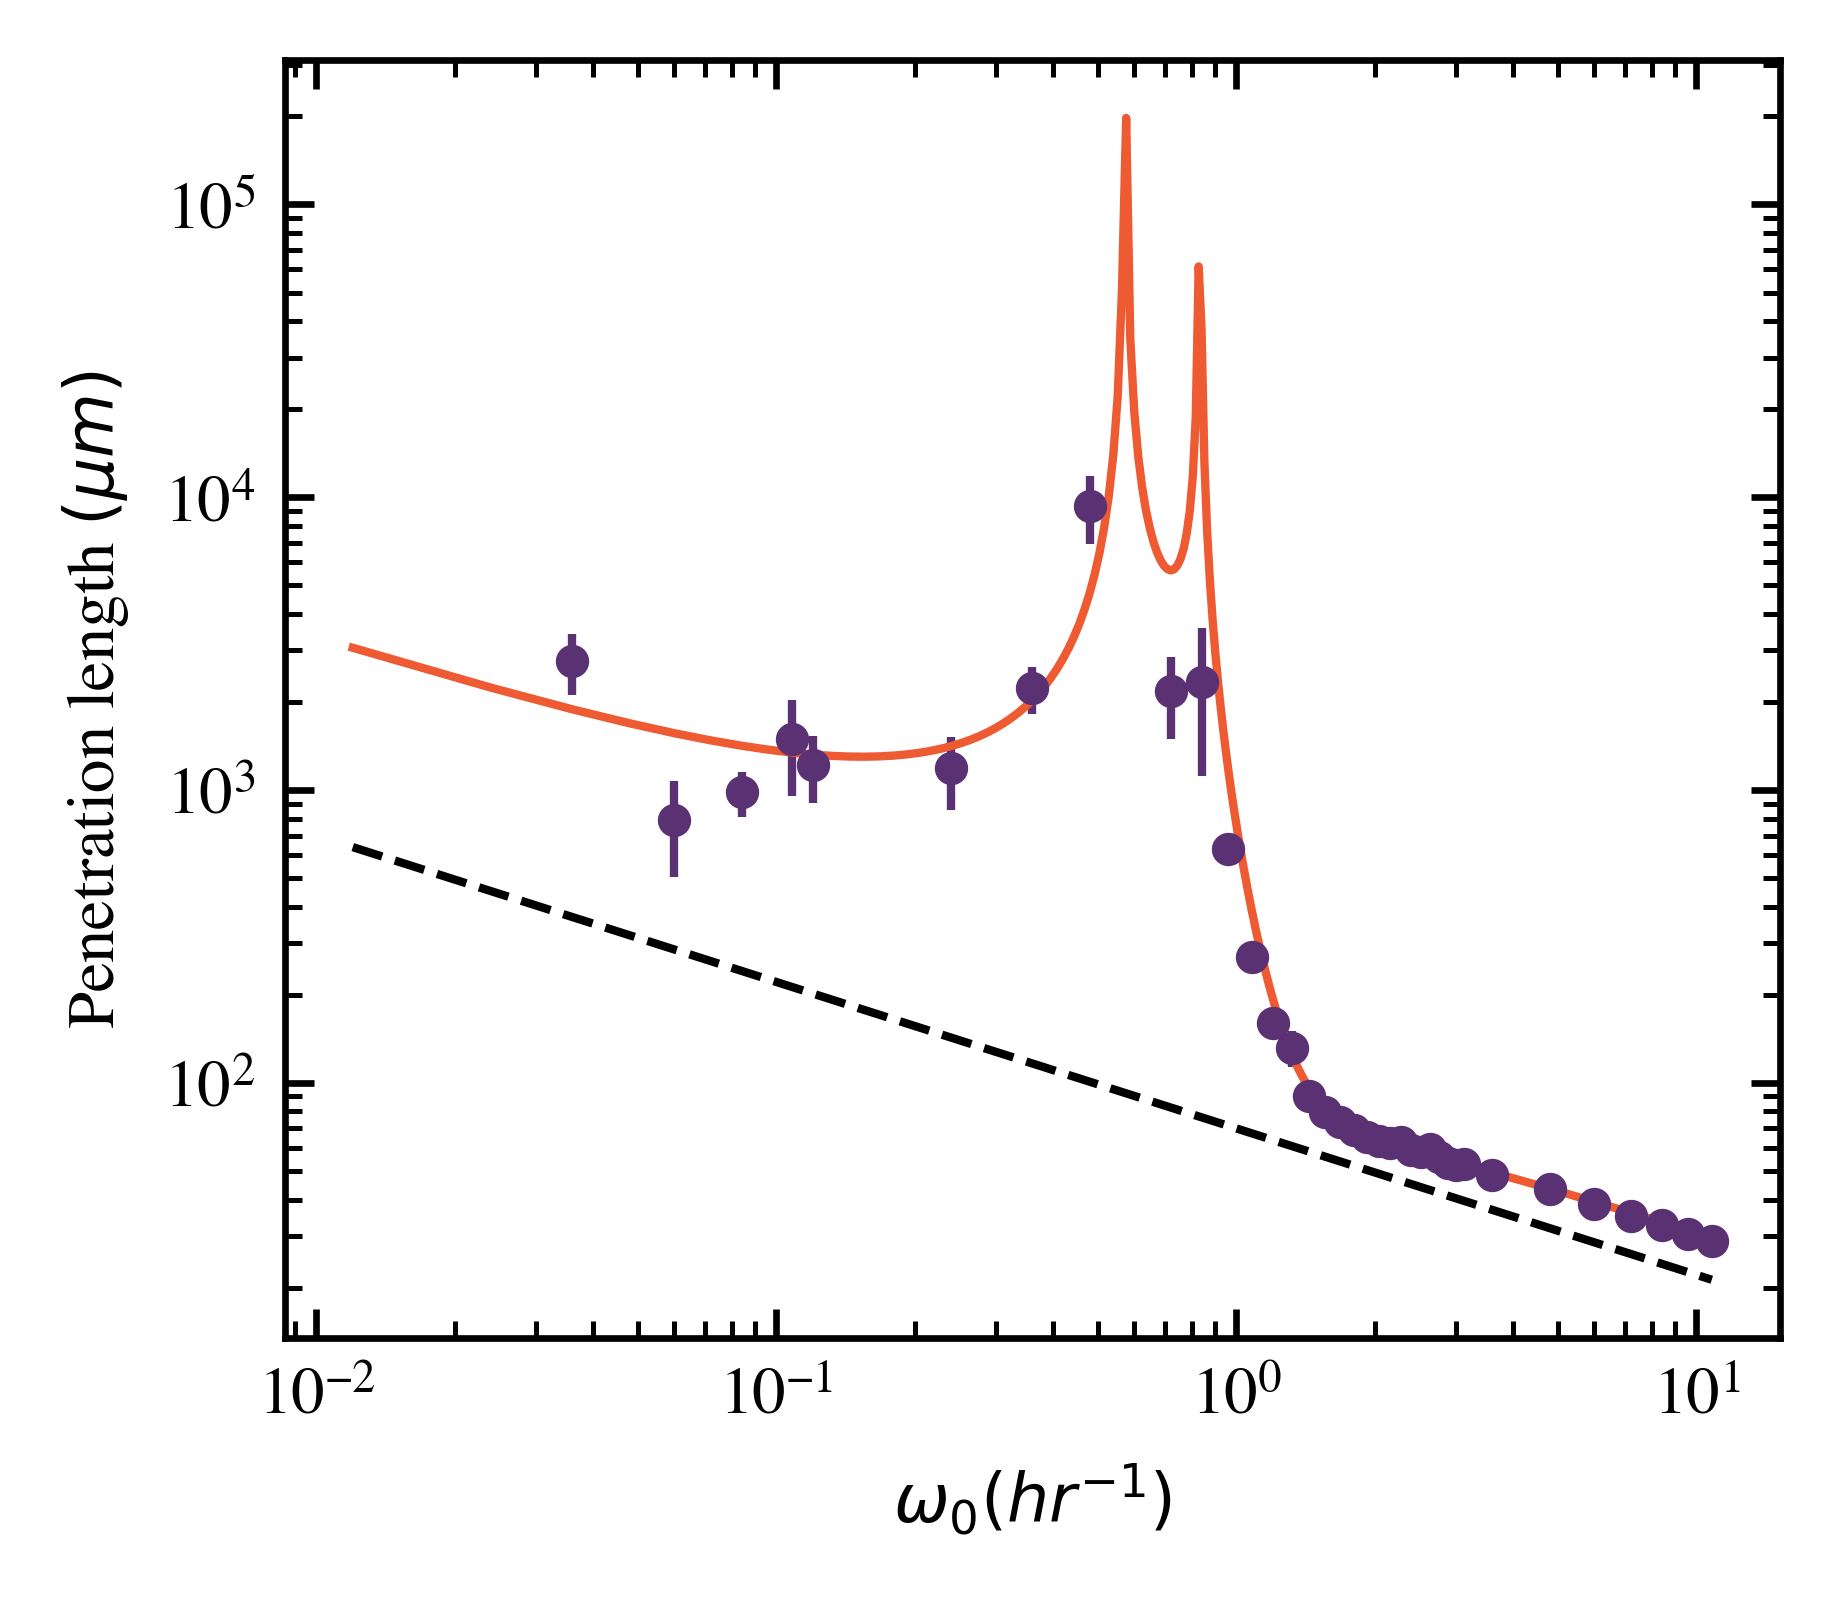

In [4]:
n=0#15
ax=plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
i=0
omega=np.arange(0.001, omega0s[-1],0.001)*12
womega0s = np.delete(omega0s, 8)
wplensm = np.delete(plensm, 8, axis=2)
#print(womega0s*12, wplensm)
ax.errorbar(womega0s[:]*12, np.mean(wplensm[i,:,:],axis=0).T,yerr=np.std(wplensm[i,:,:],axis=0),marker='o',linestyle='', color='#5a3173')
#plt.plot(np.arange(omega0s[n], omega0s[-1],0.005)*12, 20/np.real(B(np.arange(omega0s[n], omega0s[-1],0.005),20,50,10)), color='#ee5a31')
ax.plot(omega, 20/np.real(B(omega/12,20,50,10)), color='#ee5a31')
ax.plot(omega, 70/np.sqrt(omega), linestyle='dashed',c='k')
#plt.plot(omega0s[n:]*12, plensm[:,n:].T, label=[49,50,51,60,75,100])
#plt.errorbar(np.log(omega0s[n:]*12), np.log(np.mean(plensm[i,:,n:],axis=0)), yerr=np.std(plensm[i,:,n:],axis=0)/np.mean(plensm[i,:,n:],axis=0), marker='o')
#plt.plot(np.log(omega0s[n+2:-2]*12), 8-np.log(omega0s[n+2:-2]*12))
ax.set_ylabel('Penetration length $(\mu m)$')
ax.set_xlabel('$\omega_0 (hr^{-1})$')
#plt.legend()
plt.savefig('penetration_length.svg')

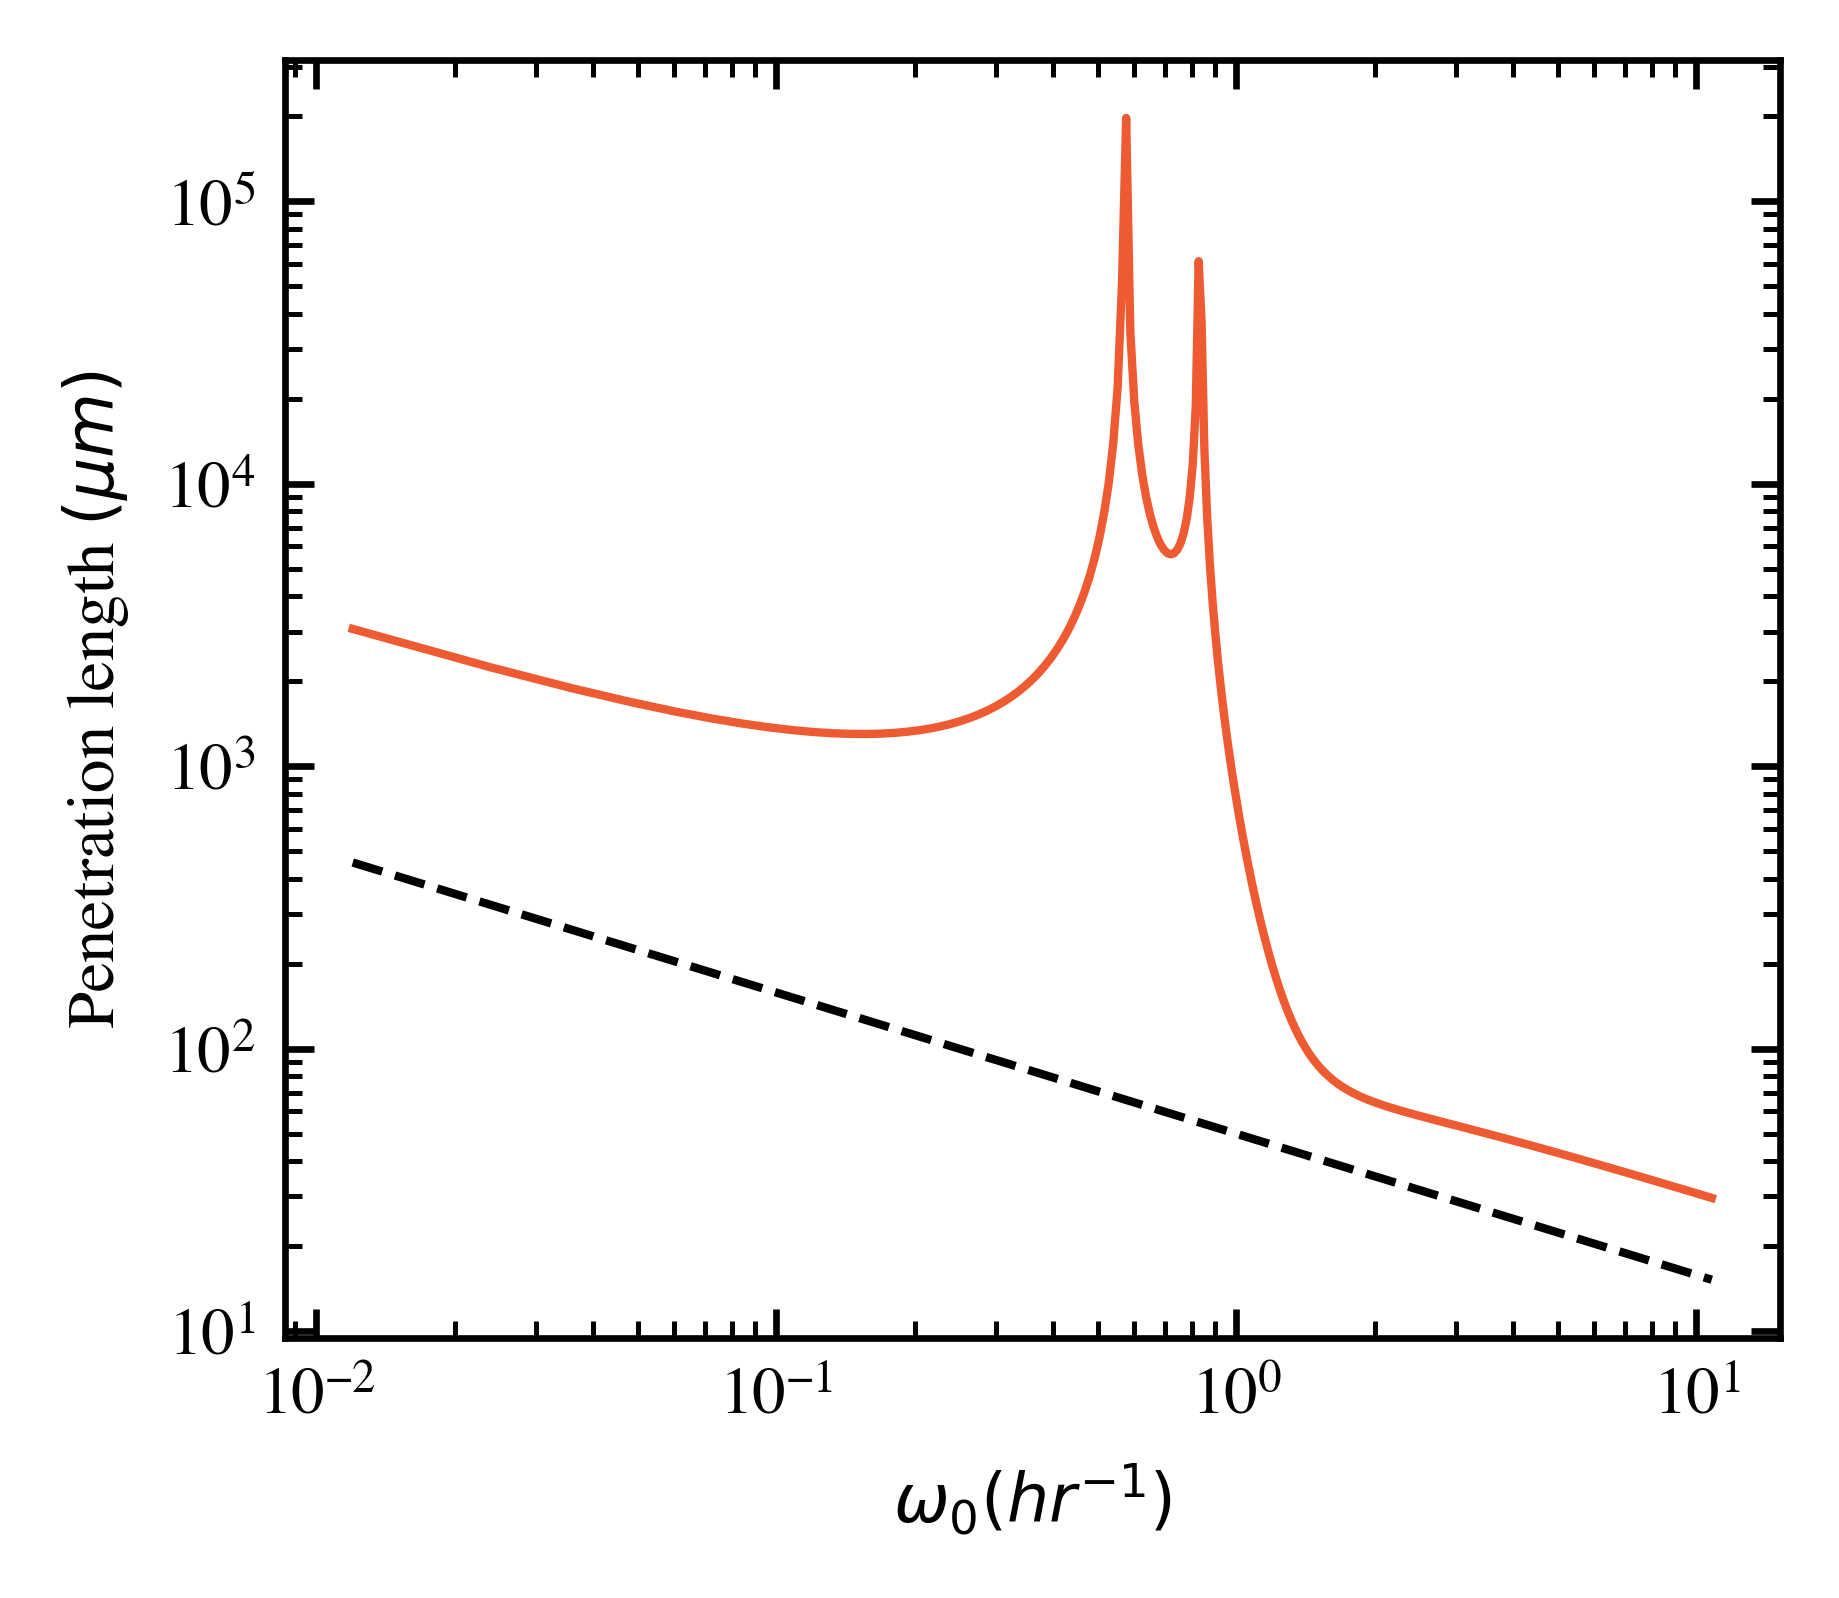

In [144]:
#theoretical expression for penetration length in its entirety
omega=np.arange(0.001, omega0s[-1],0.001)*12
plt.plot(omega, 20/np.real(B(omega/12,20,50,10)), color='#ee5a31')
plt.plot(omega, 50/np.sqrt(omega), linestyle='dashed',c='k')
plt.ylabel('Penetration length $(\mu m)$')
plt.xlabel('$\omega_0 (hr^{-1})$')
plt.xscale('log')
plt.yscale('log')
plt.show()

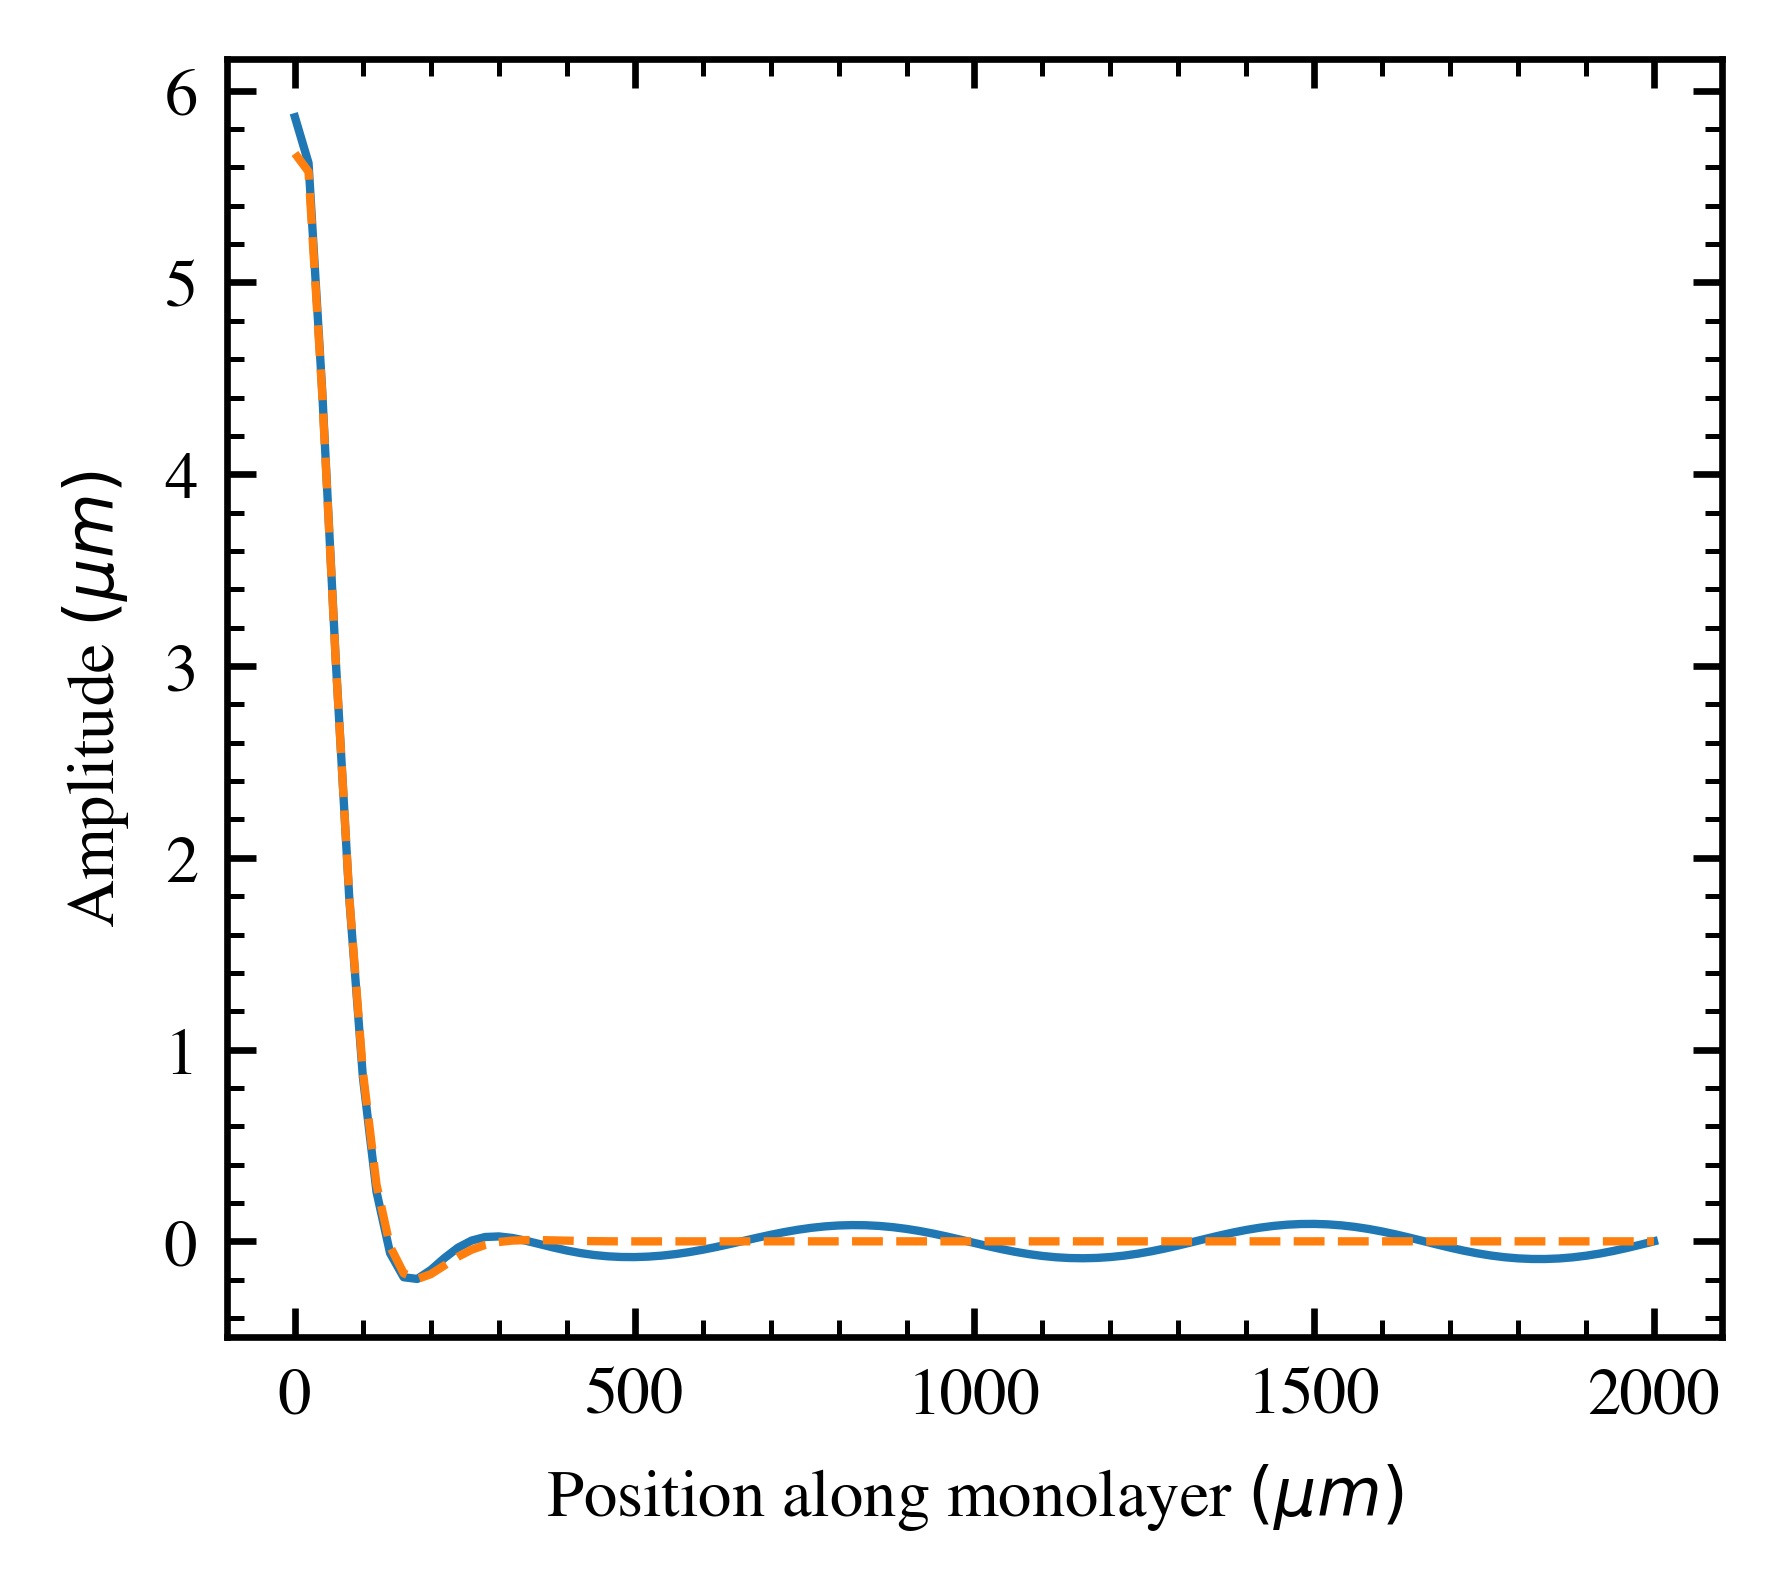

0.36972136276115575 308.4722048146617 0.3988197510230439 0.5052051120425092


In [5]:
i=-1
t=50
plt.plot(np.arange(0,N+1,1)*20,20*Bufield[i,-t,:])
plt.plot(np.arange(0,N+1,1)*20,20*decsine(np.arange(0,N+1,1), *popt), linestyle='dashed')
plt.ylabel('Amplitude $(\mu m)$')
plt.xlabel('Position along monolayer $(\mu m)$')
plt.show()
print(*popt)

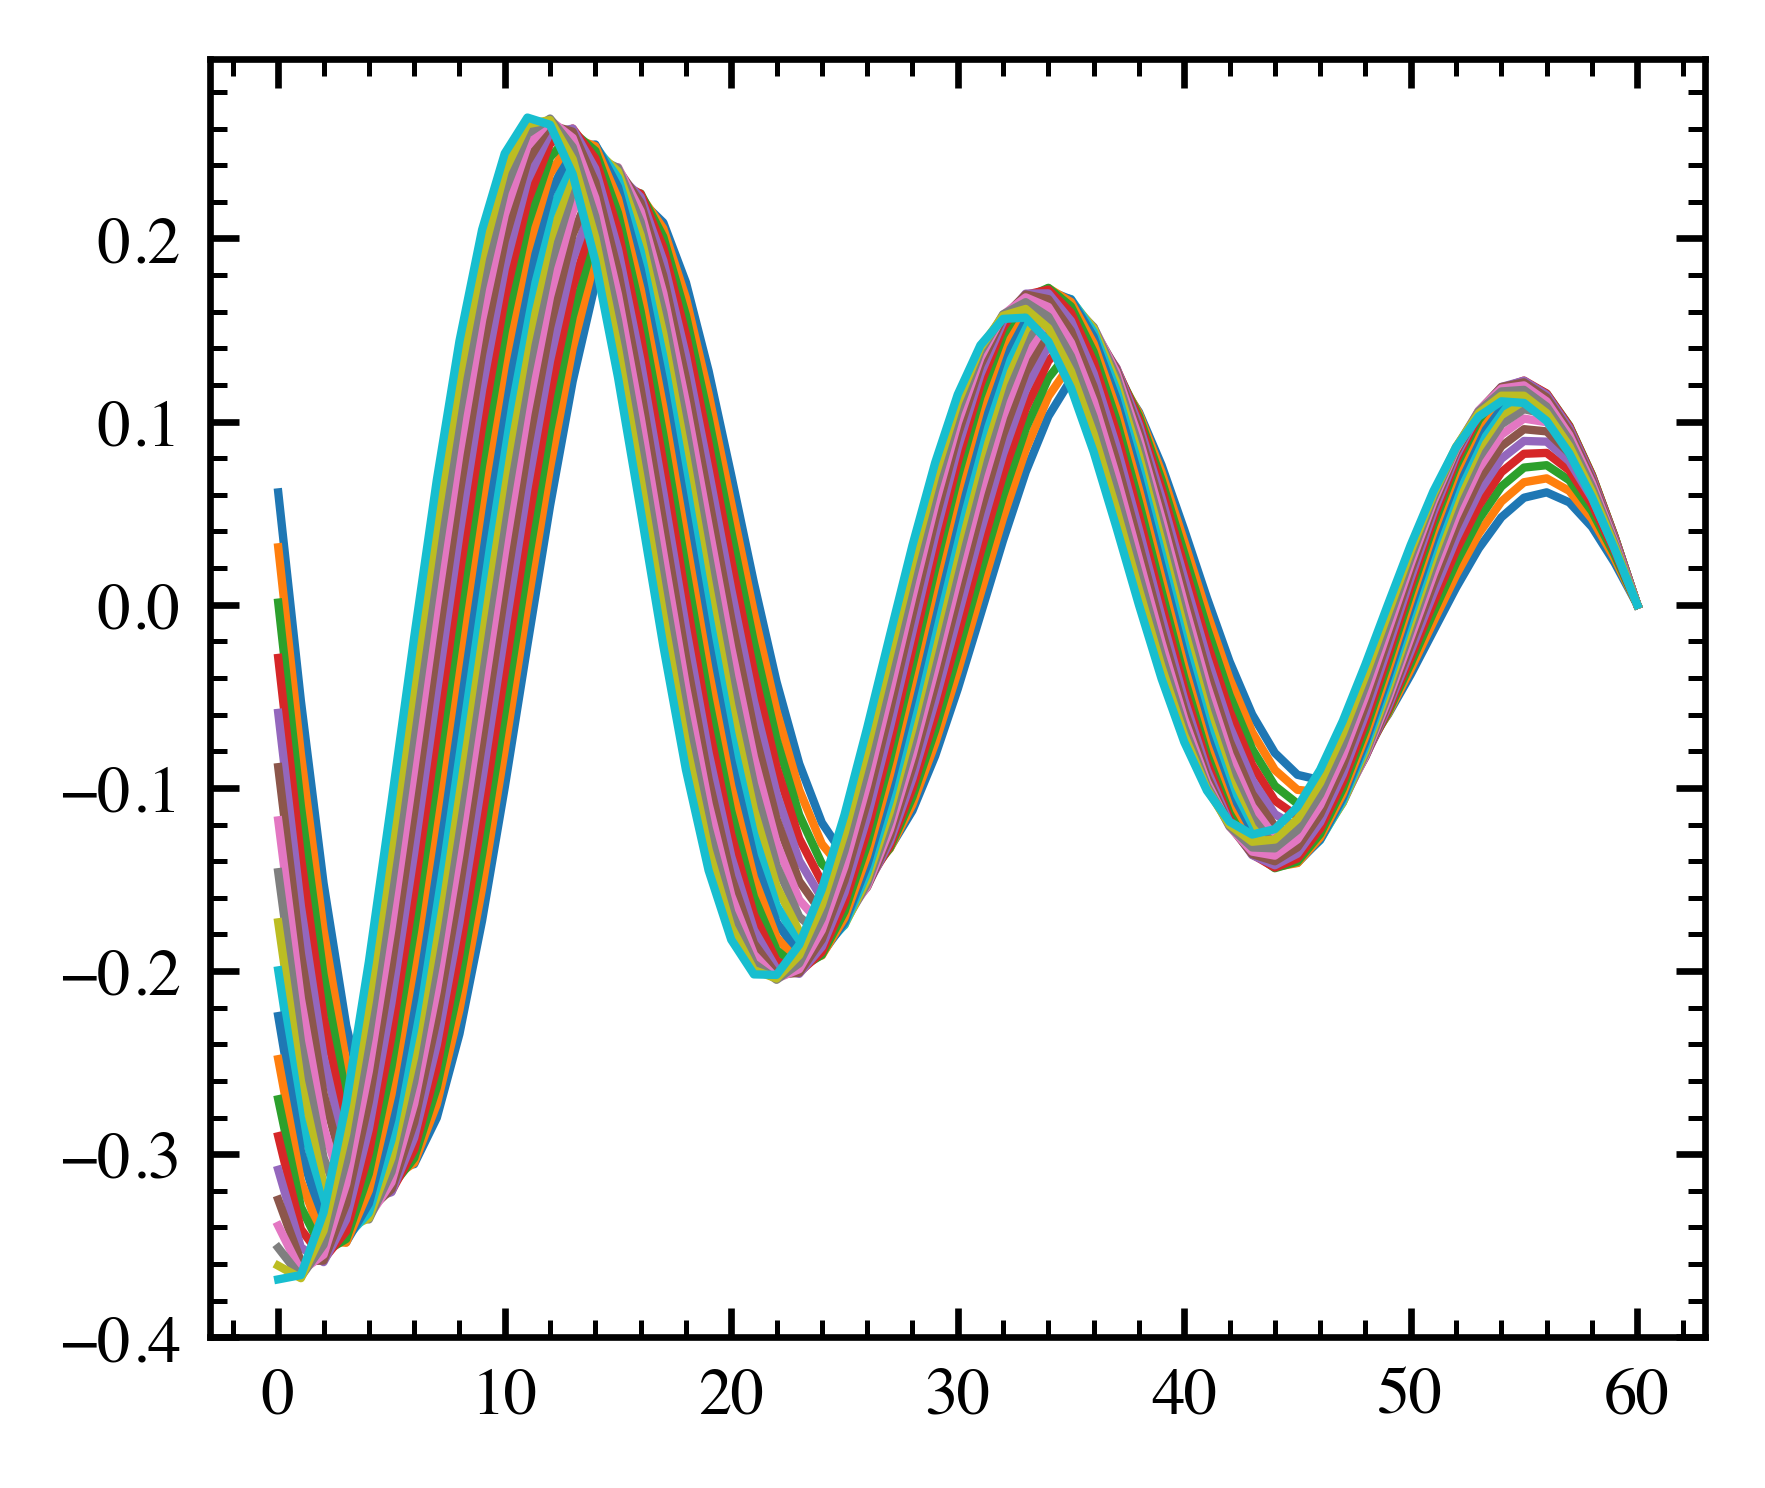

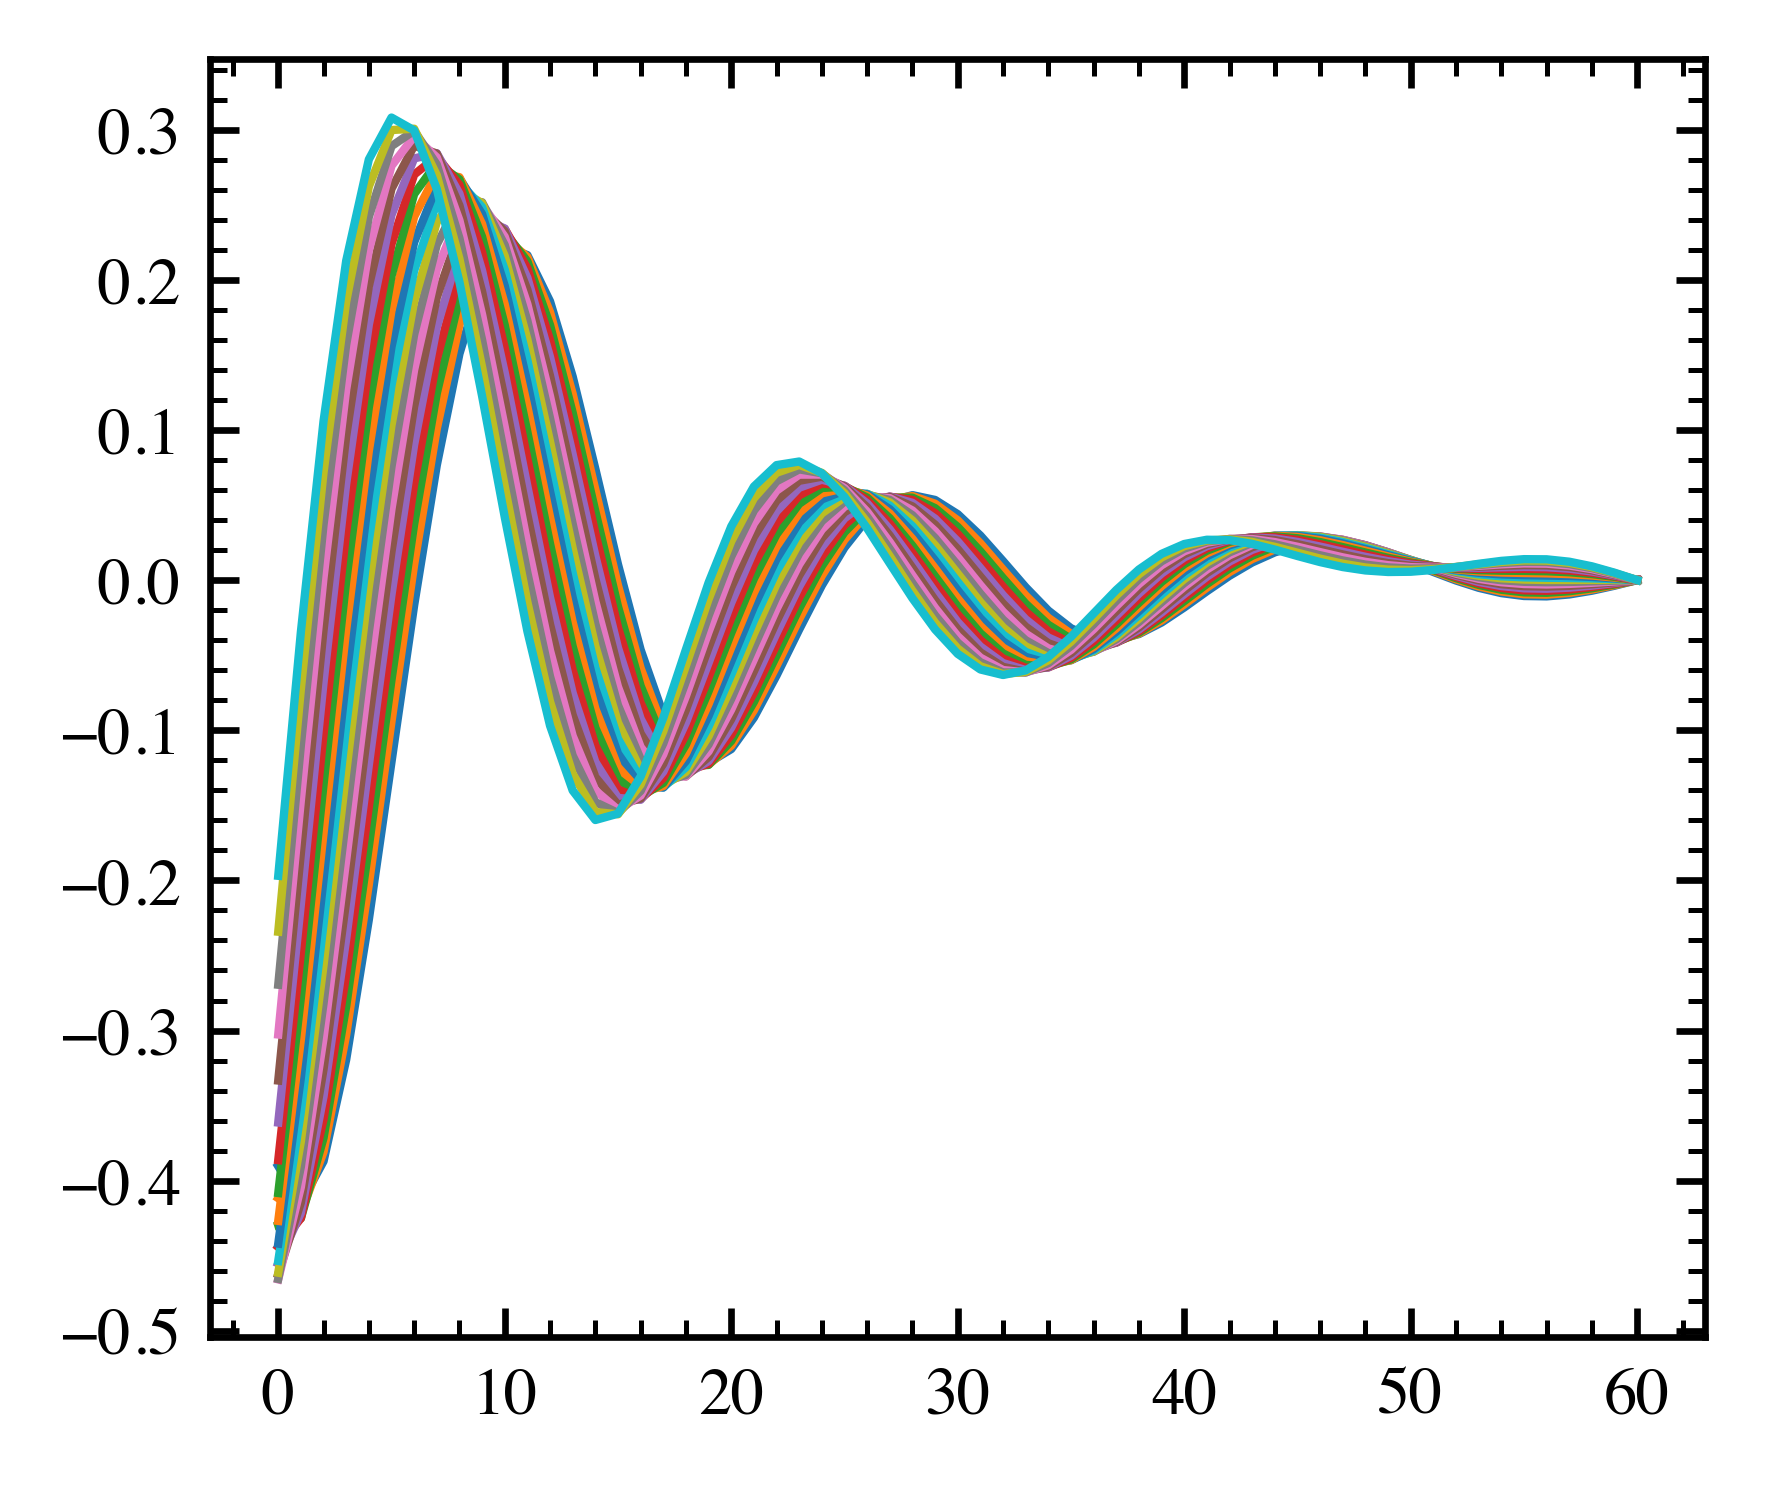

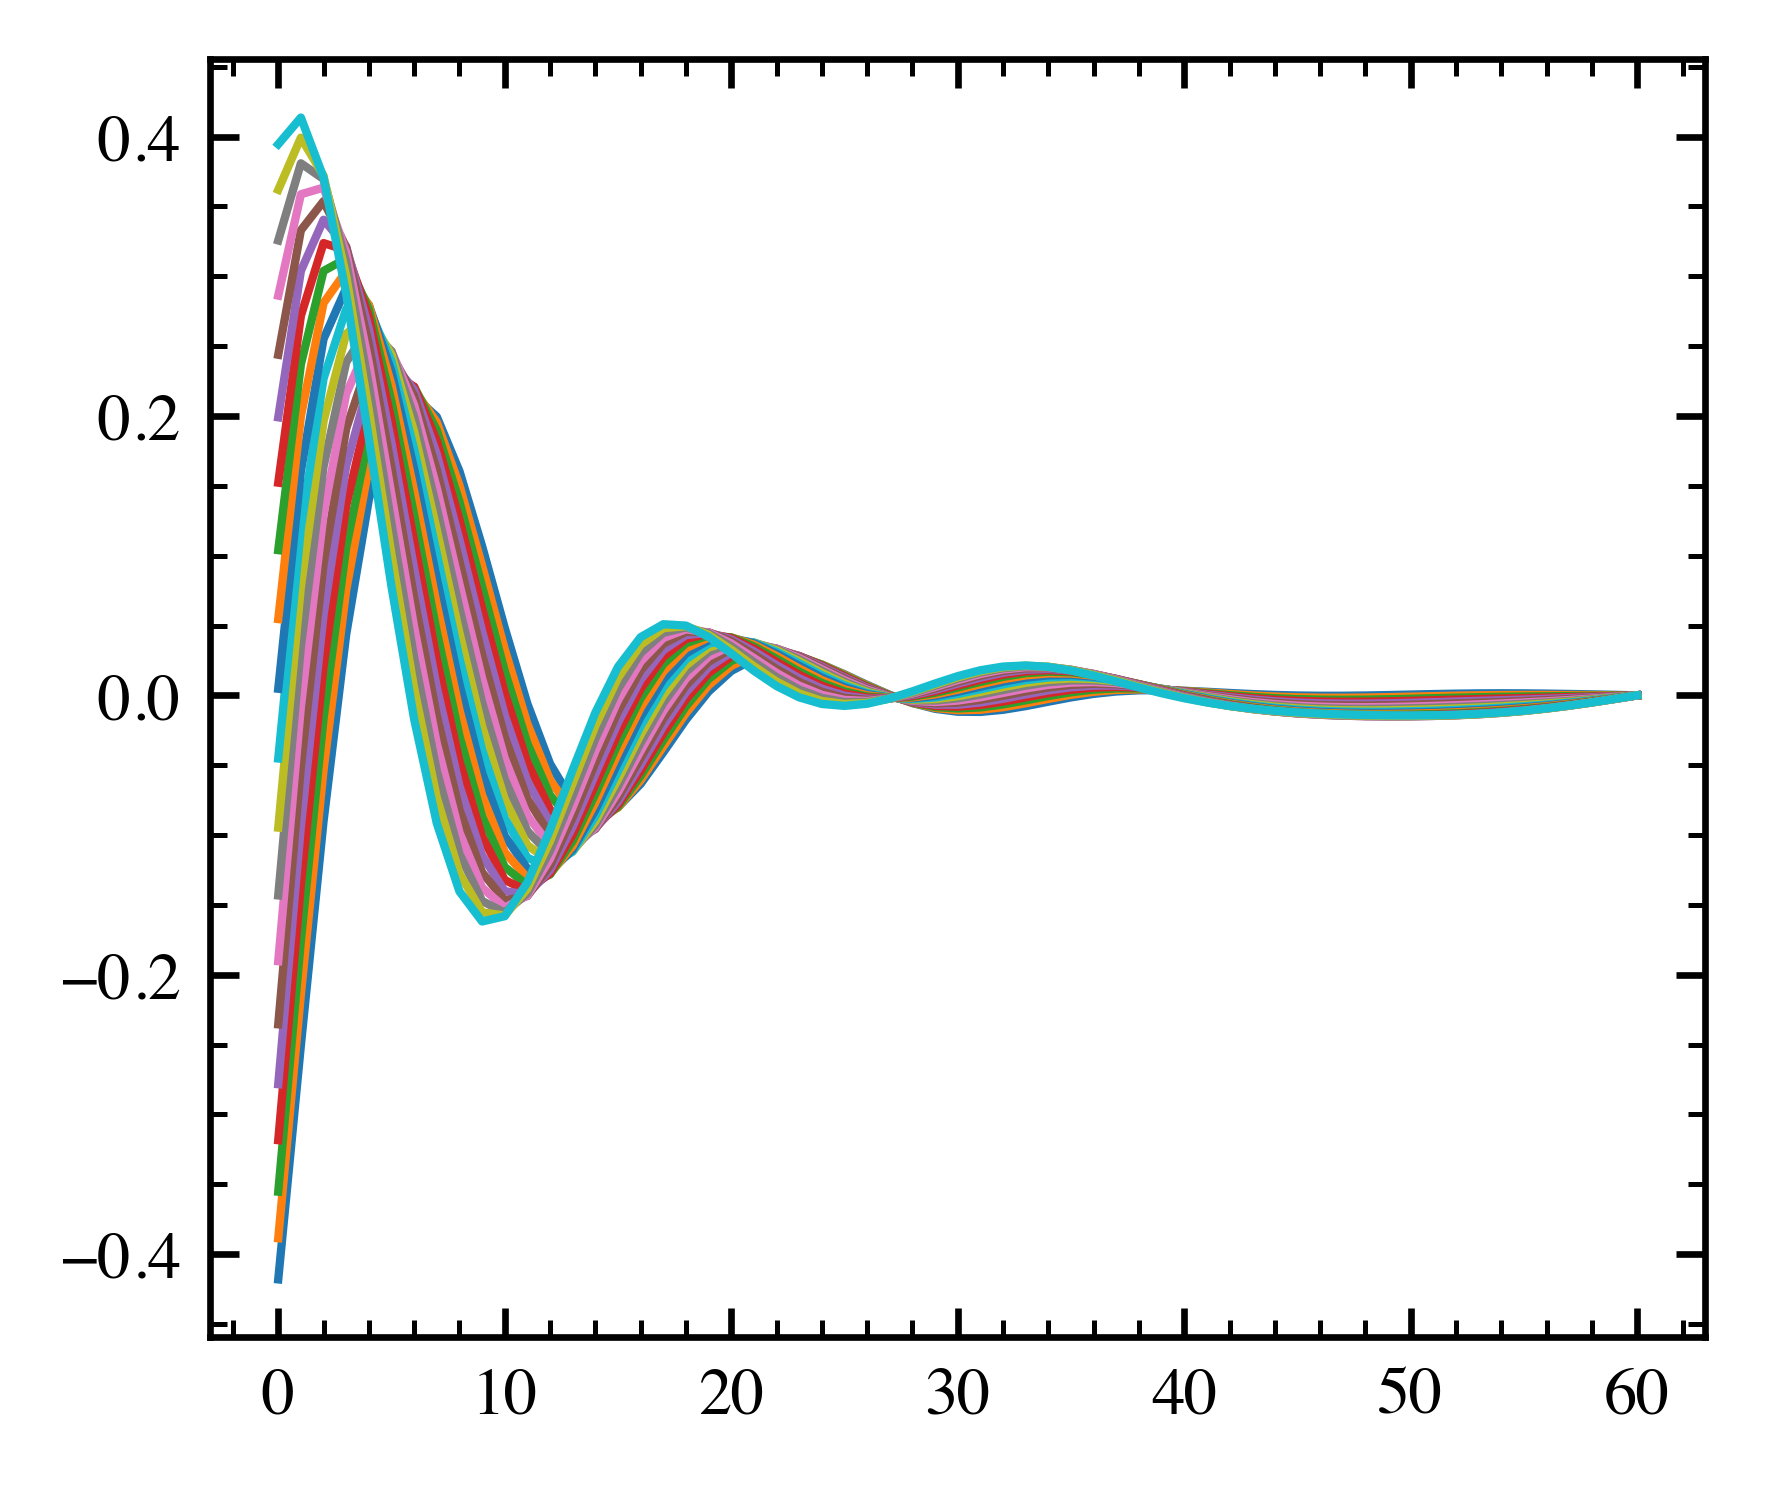

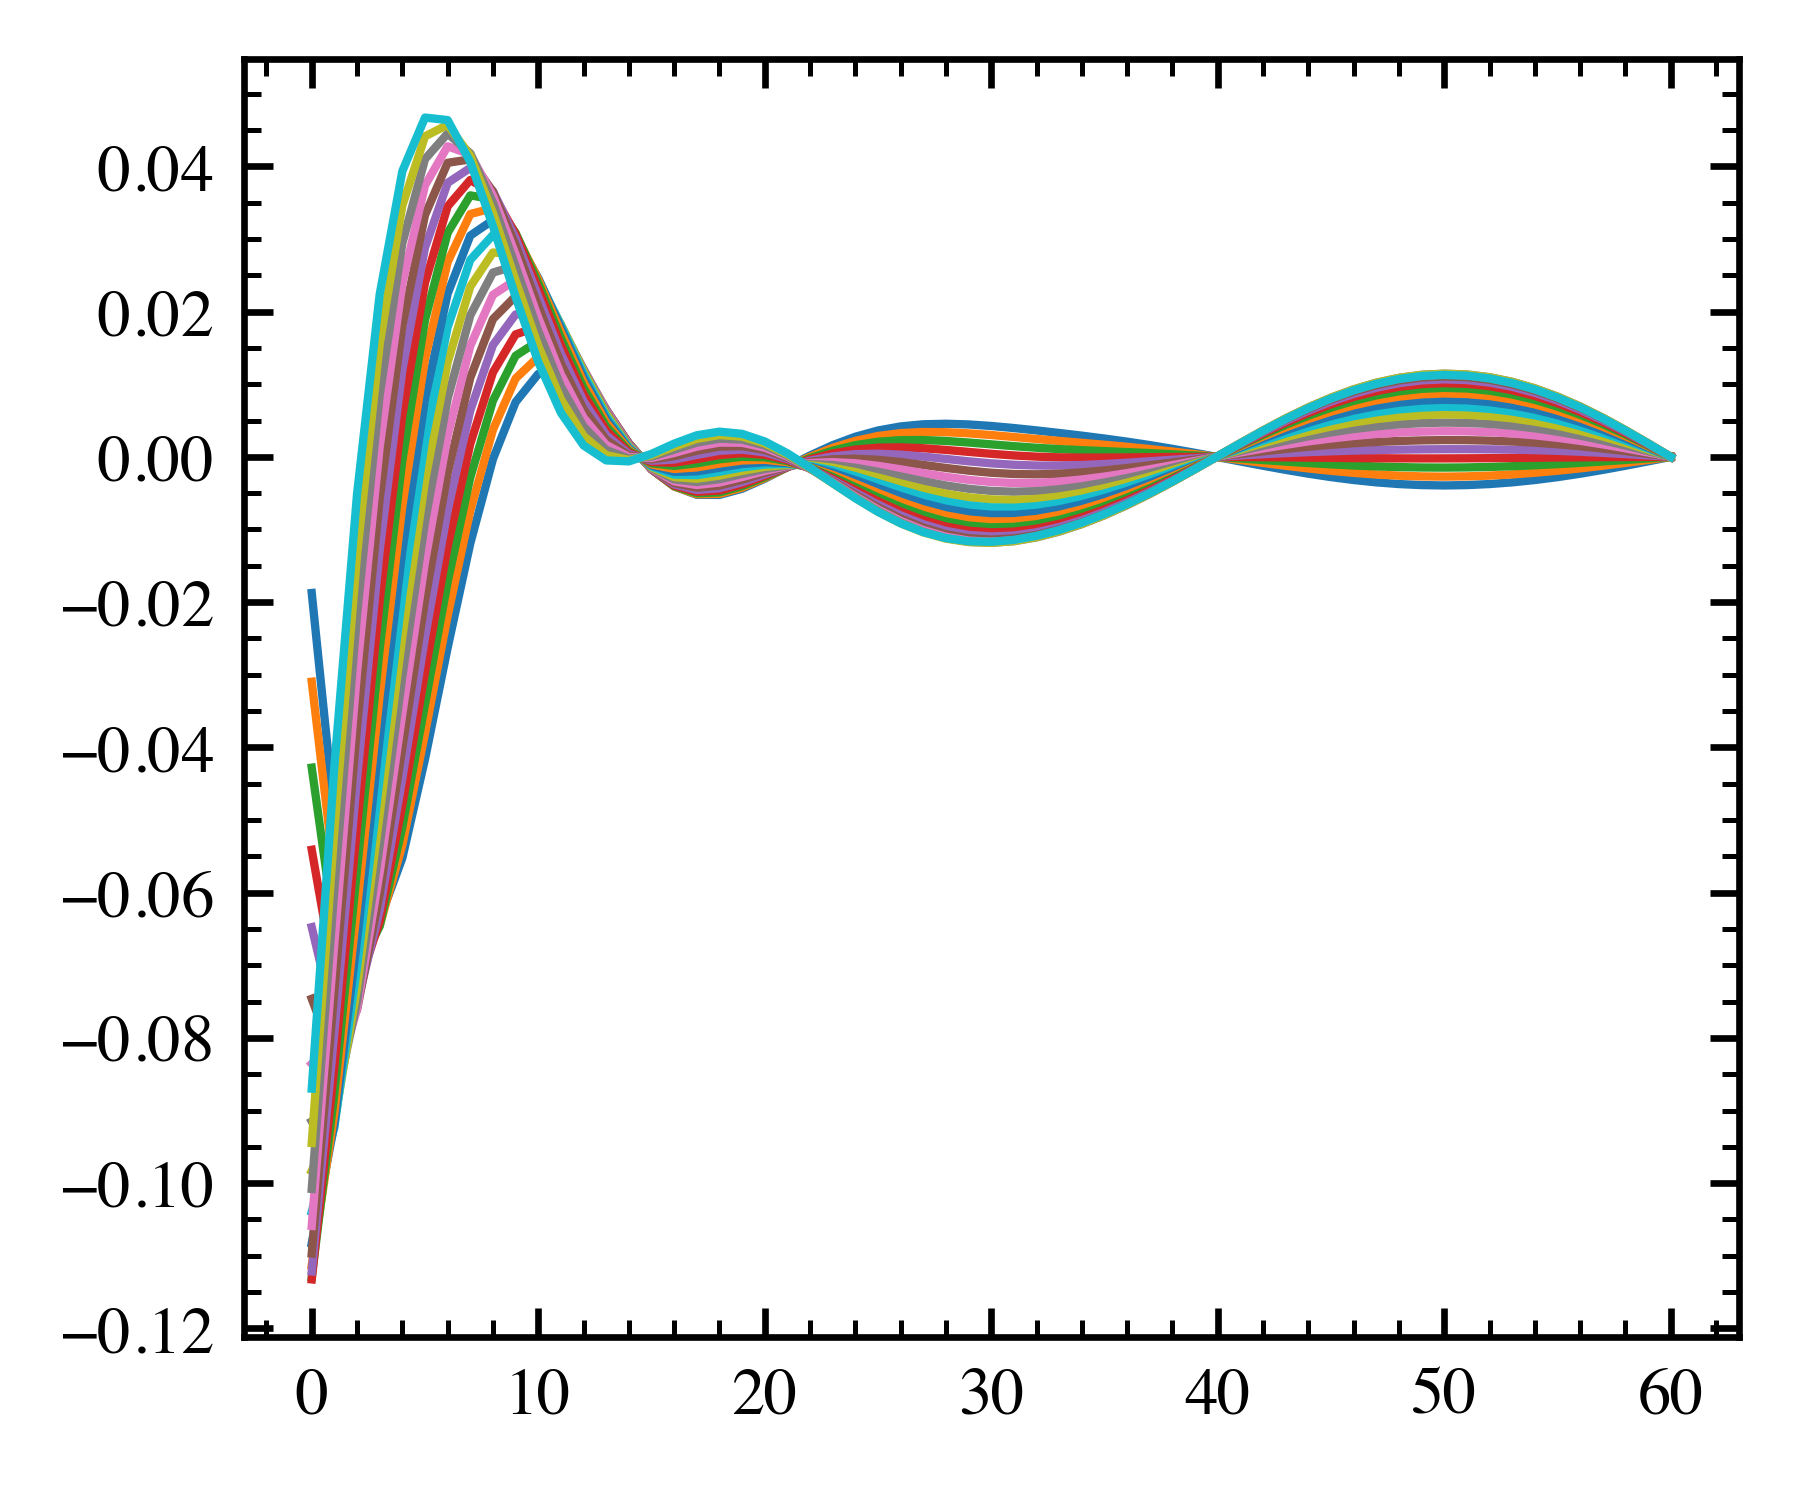

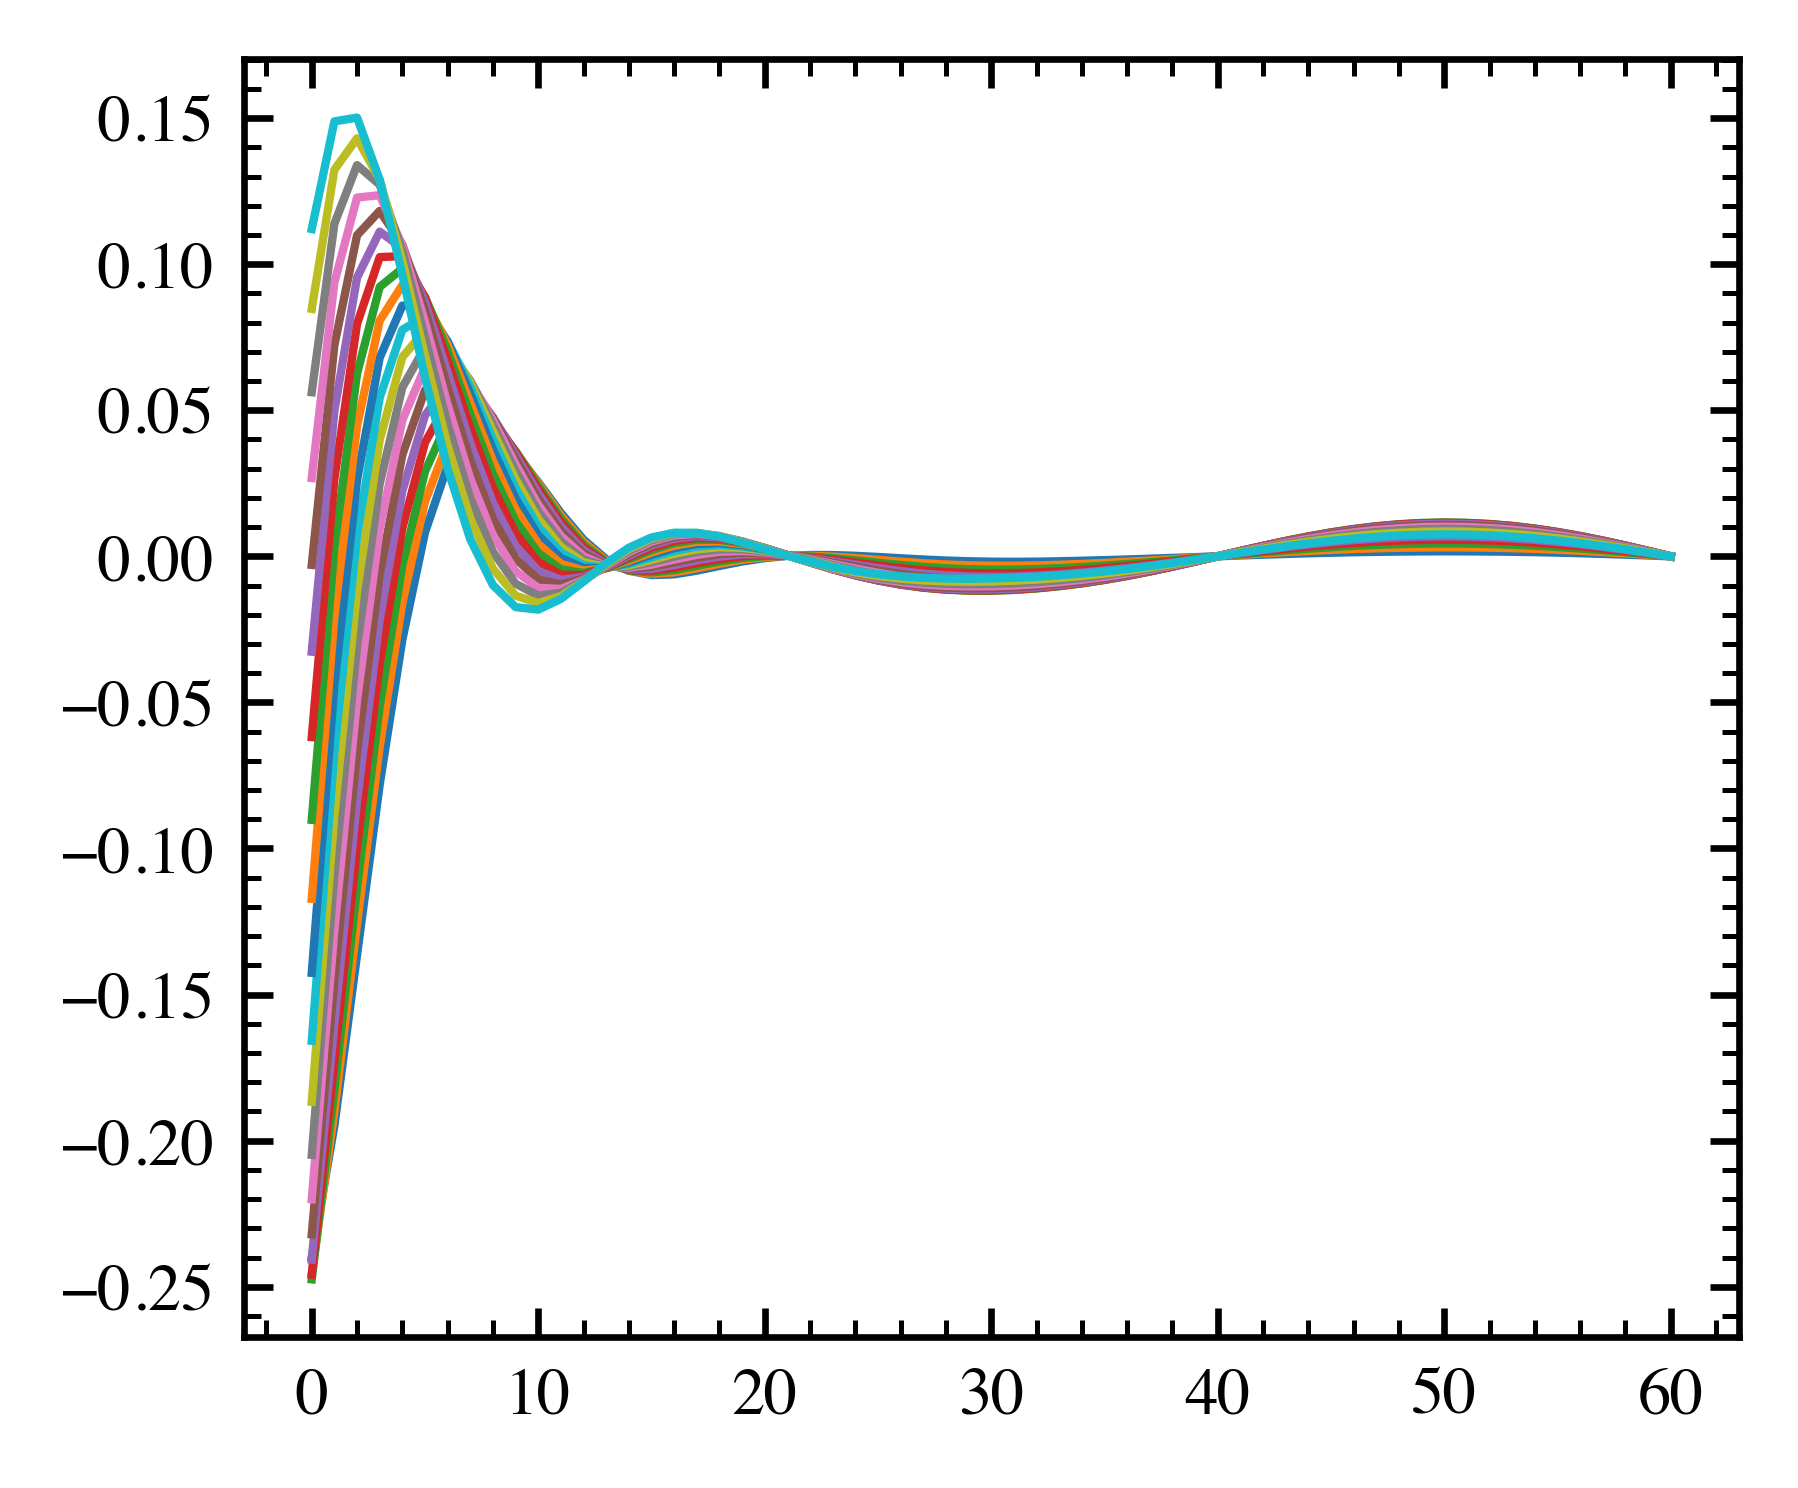

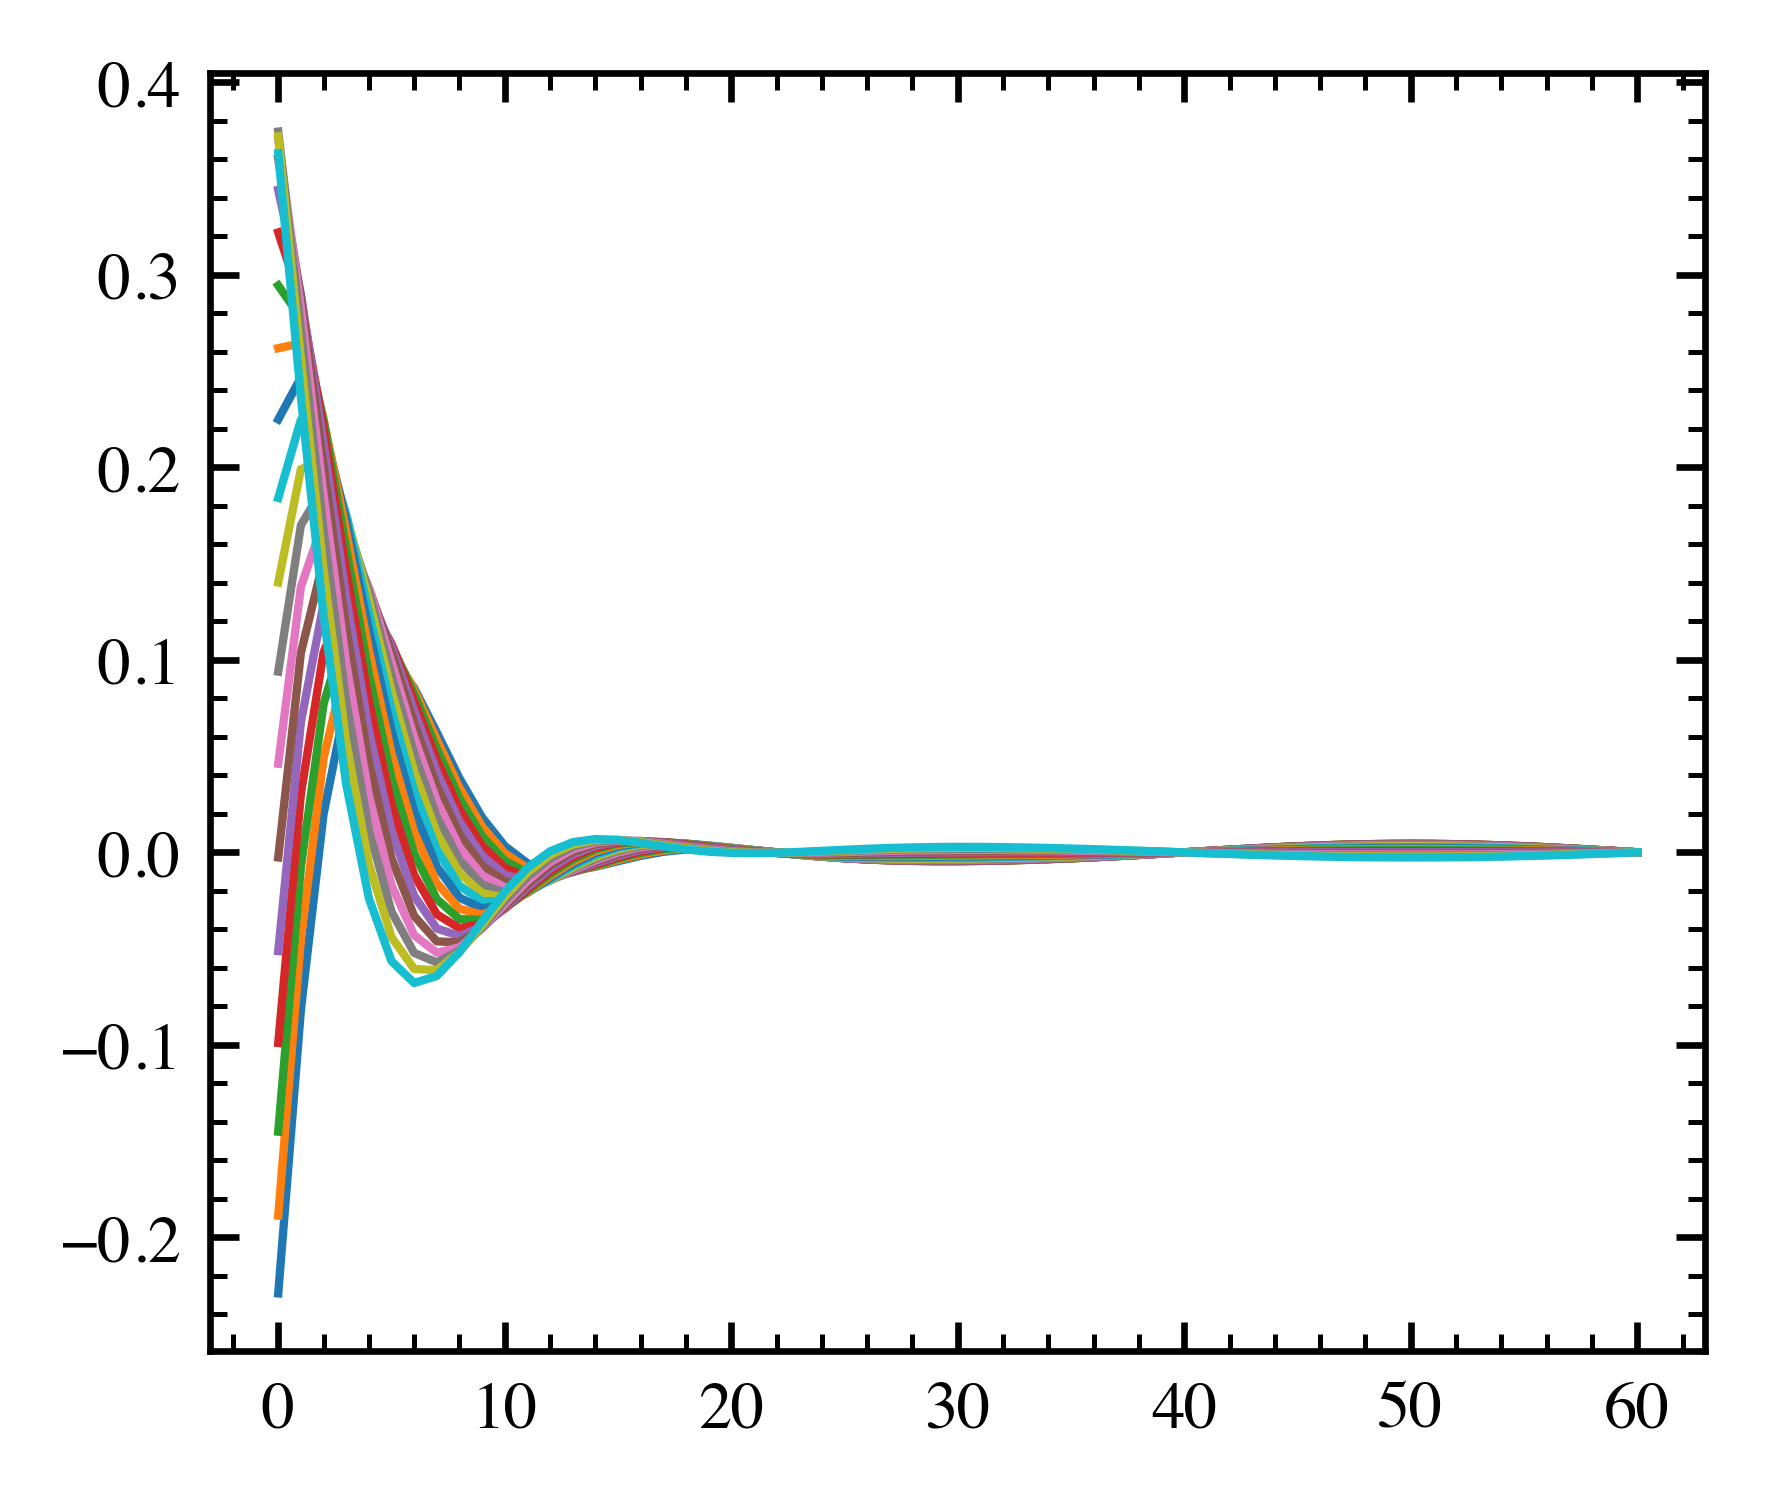

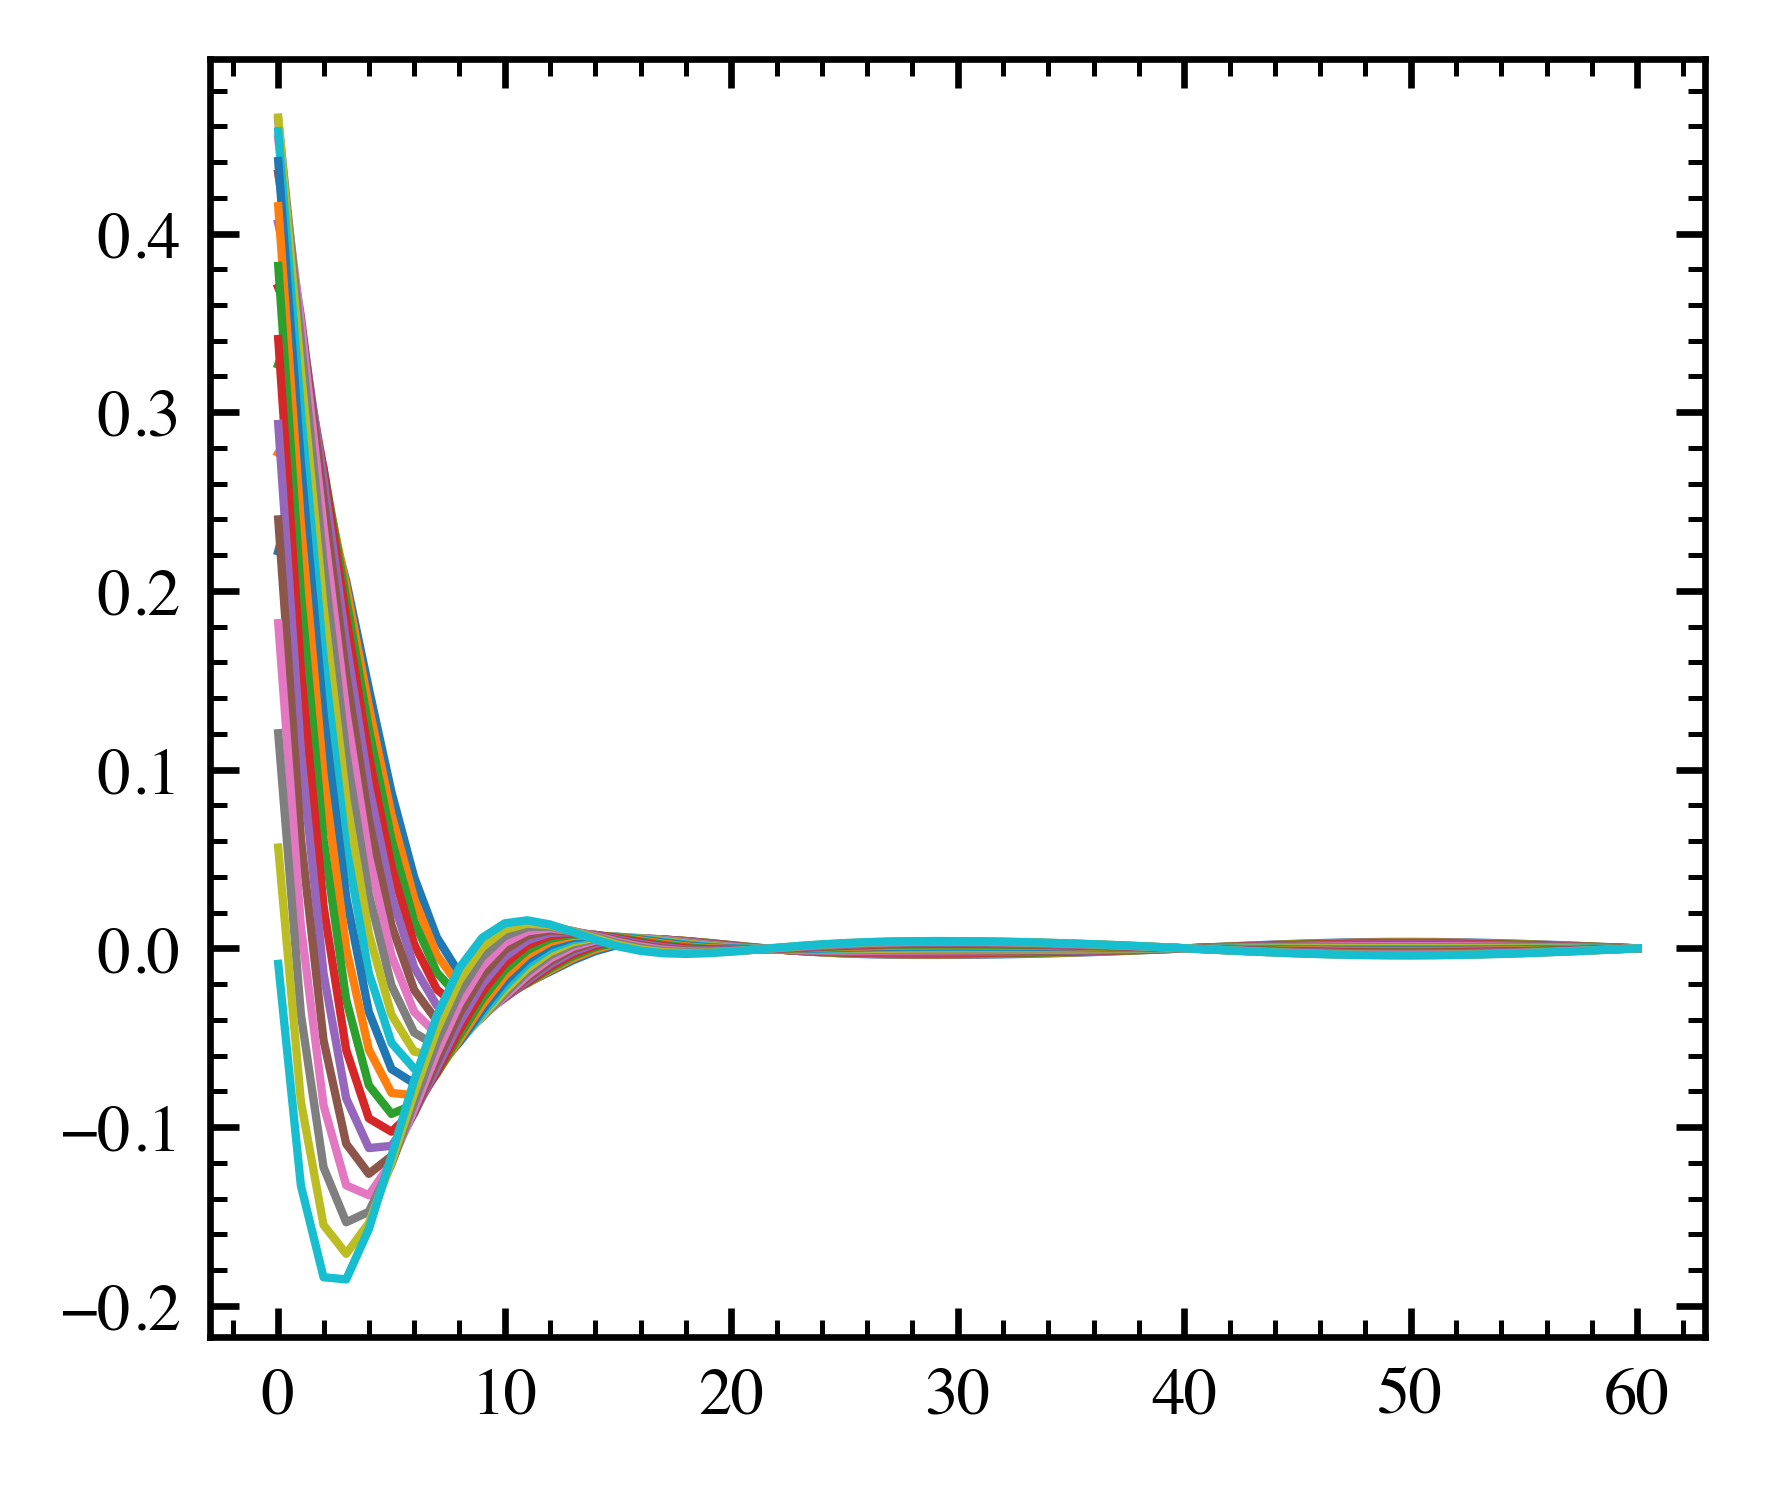

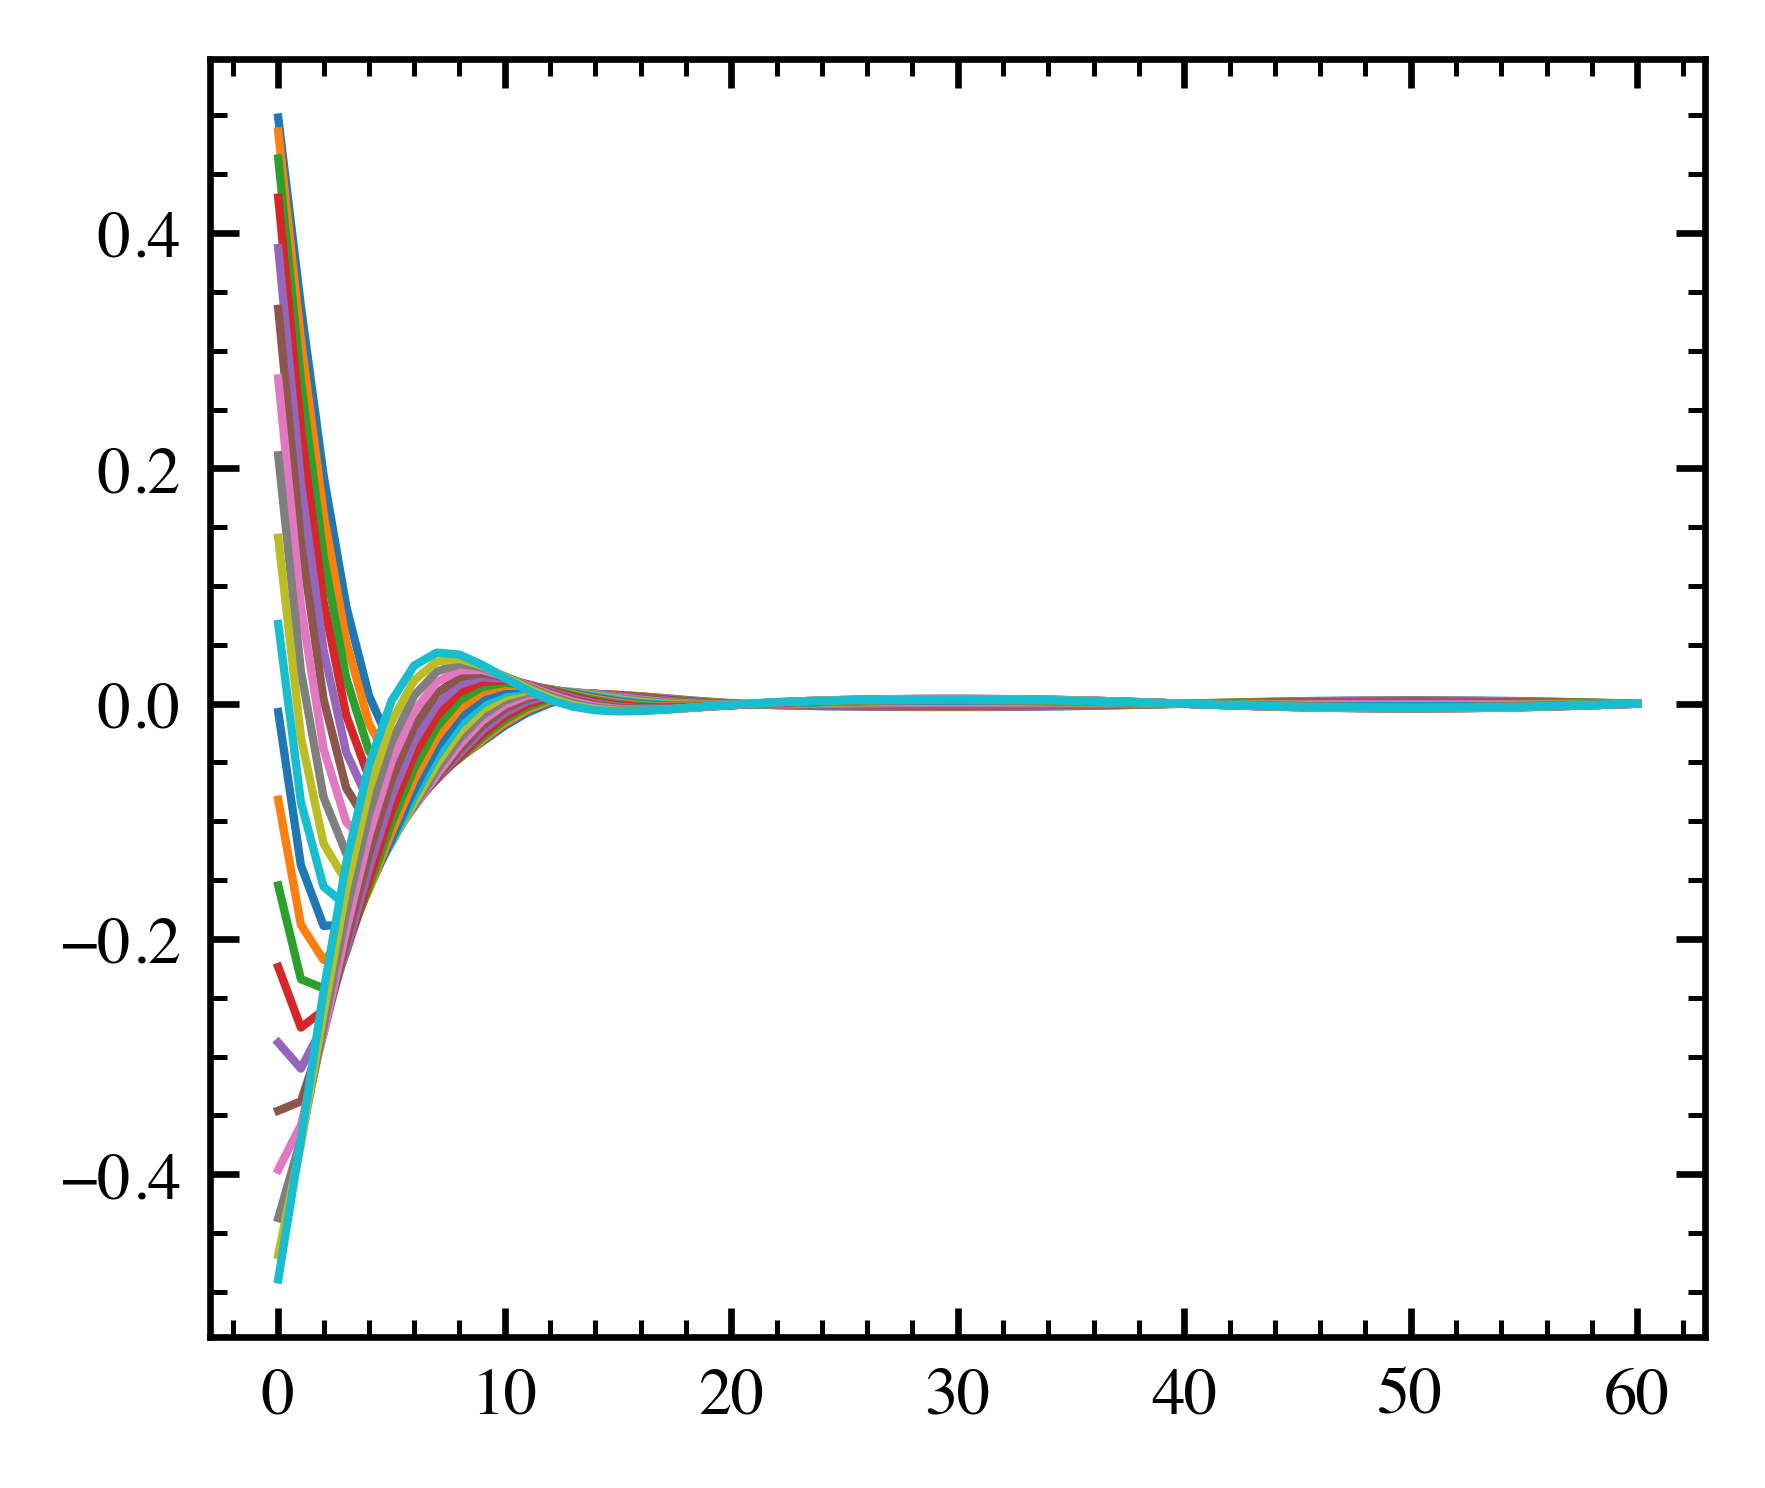

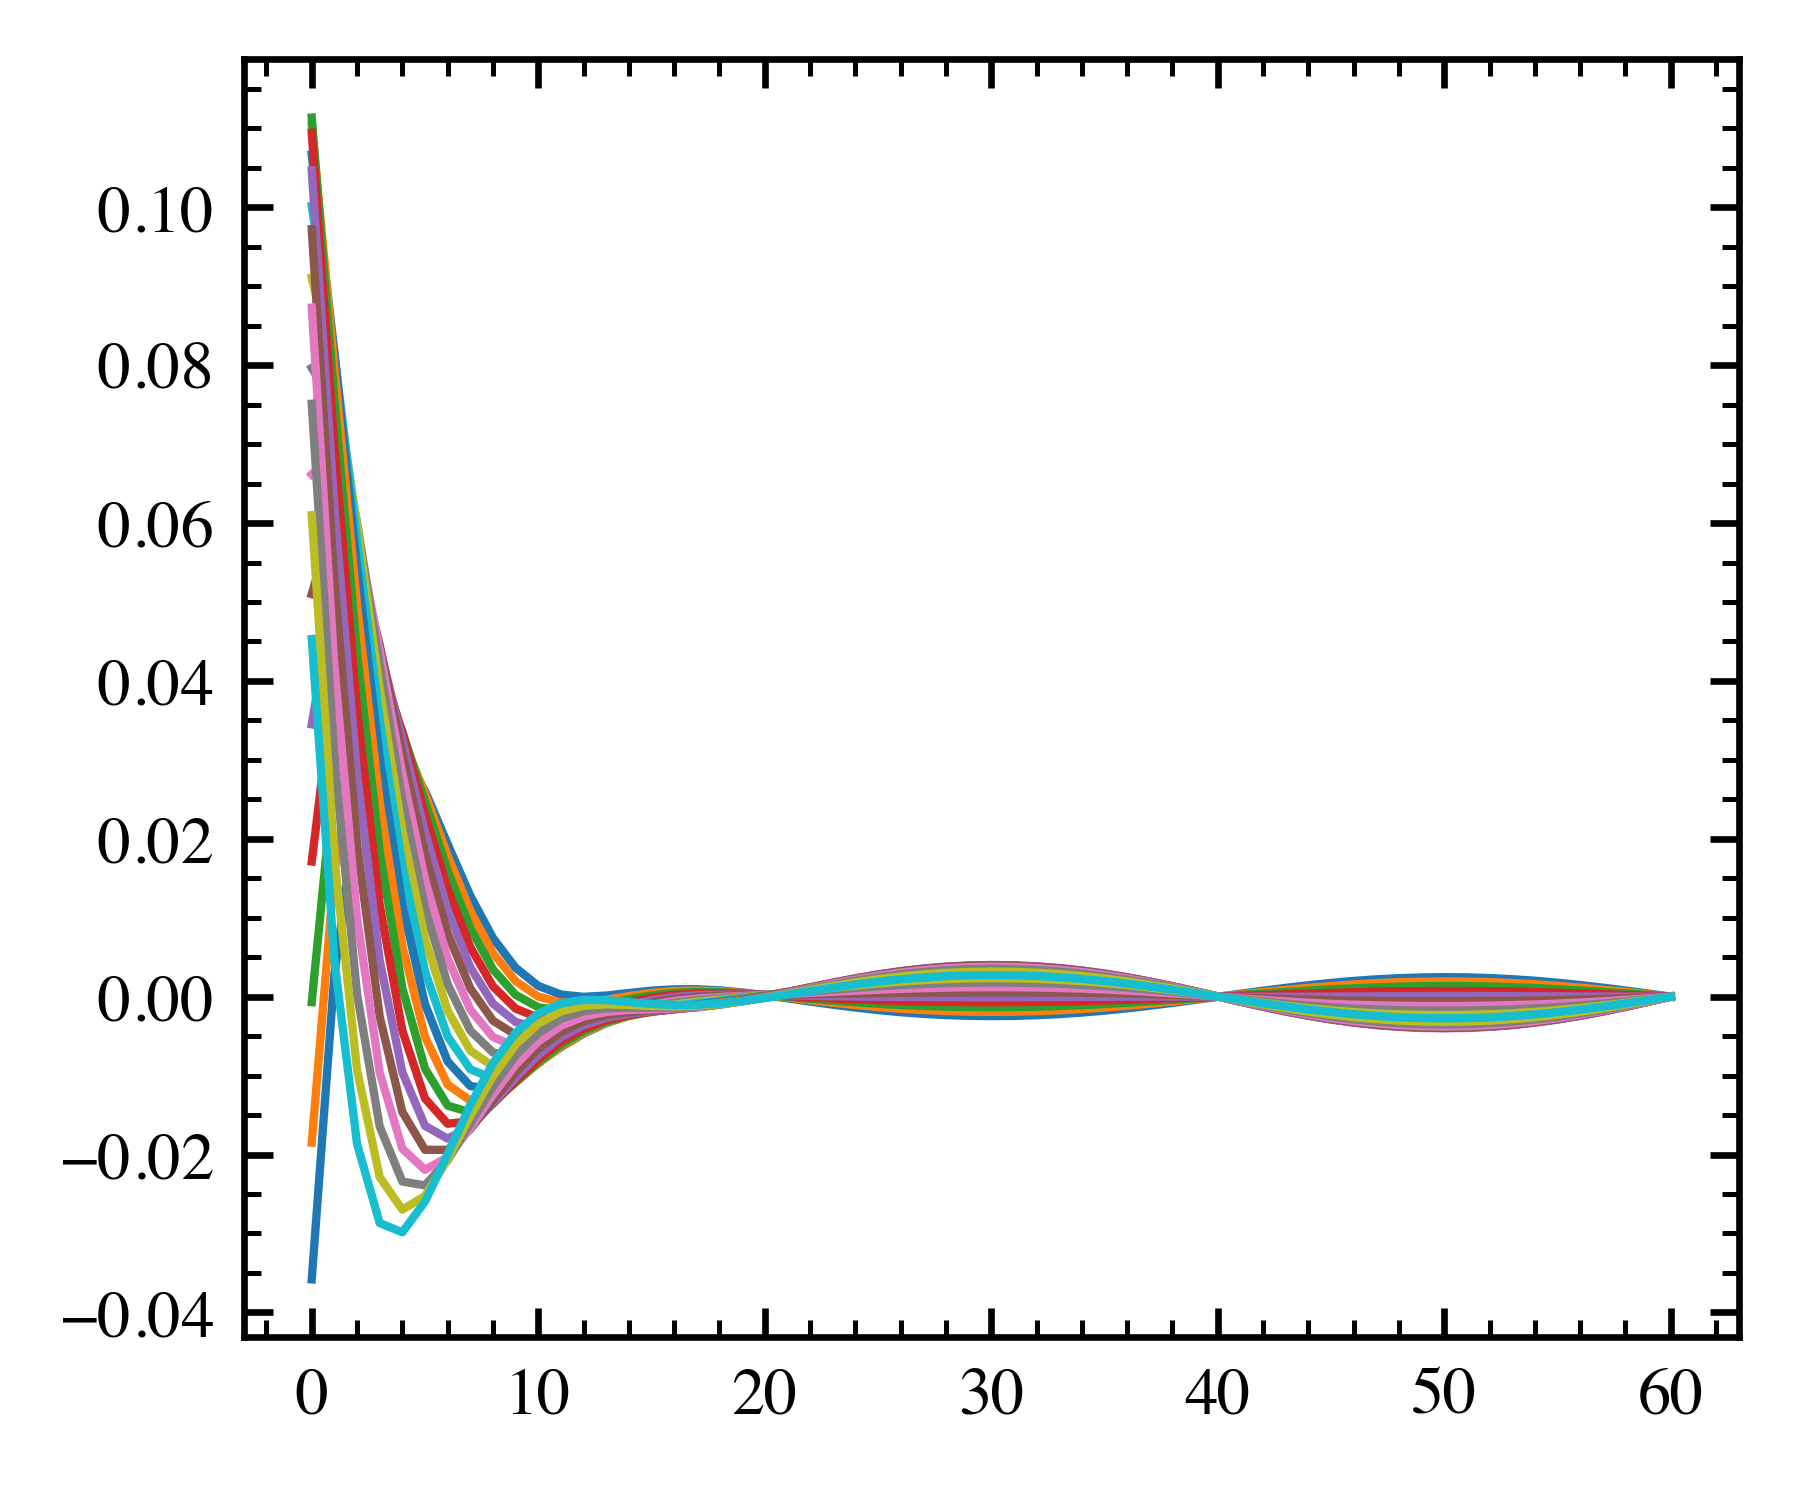

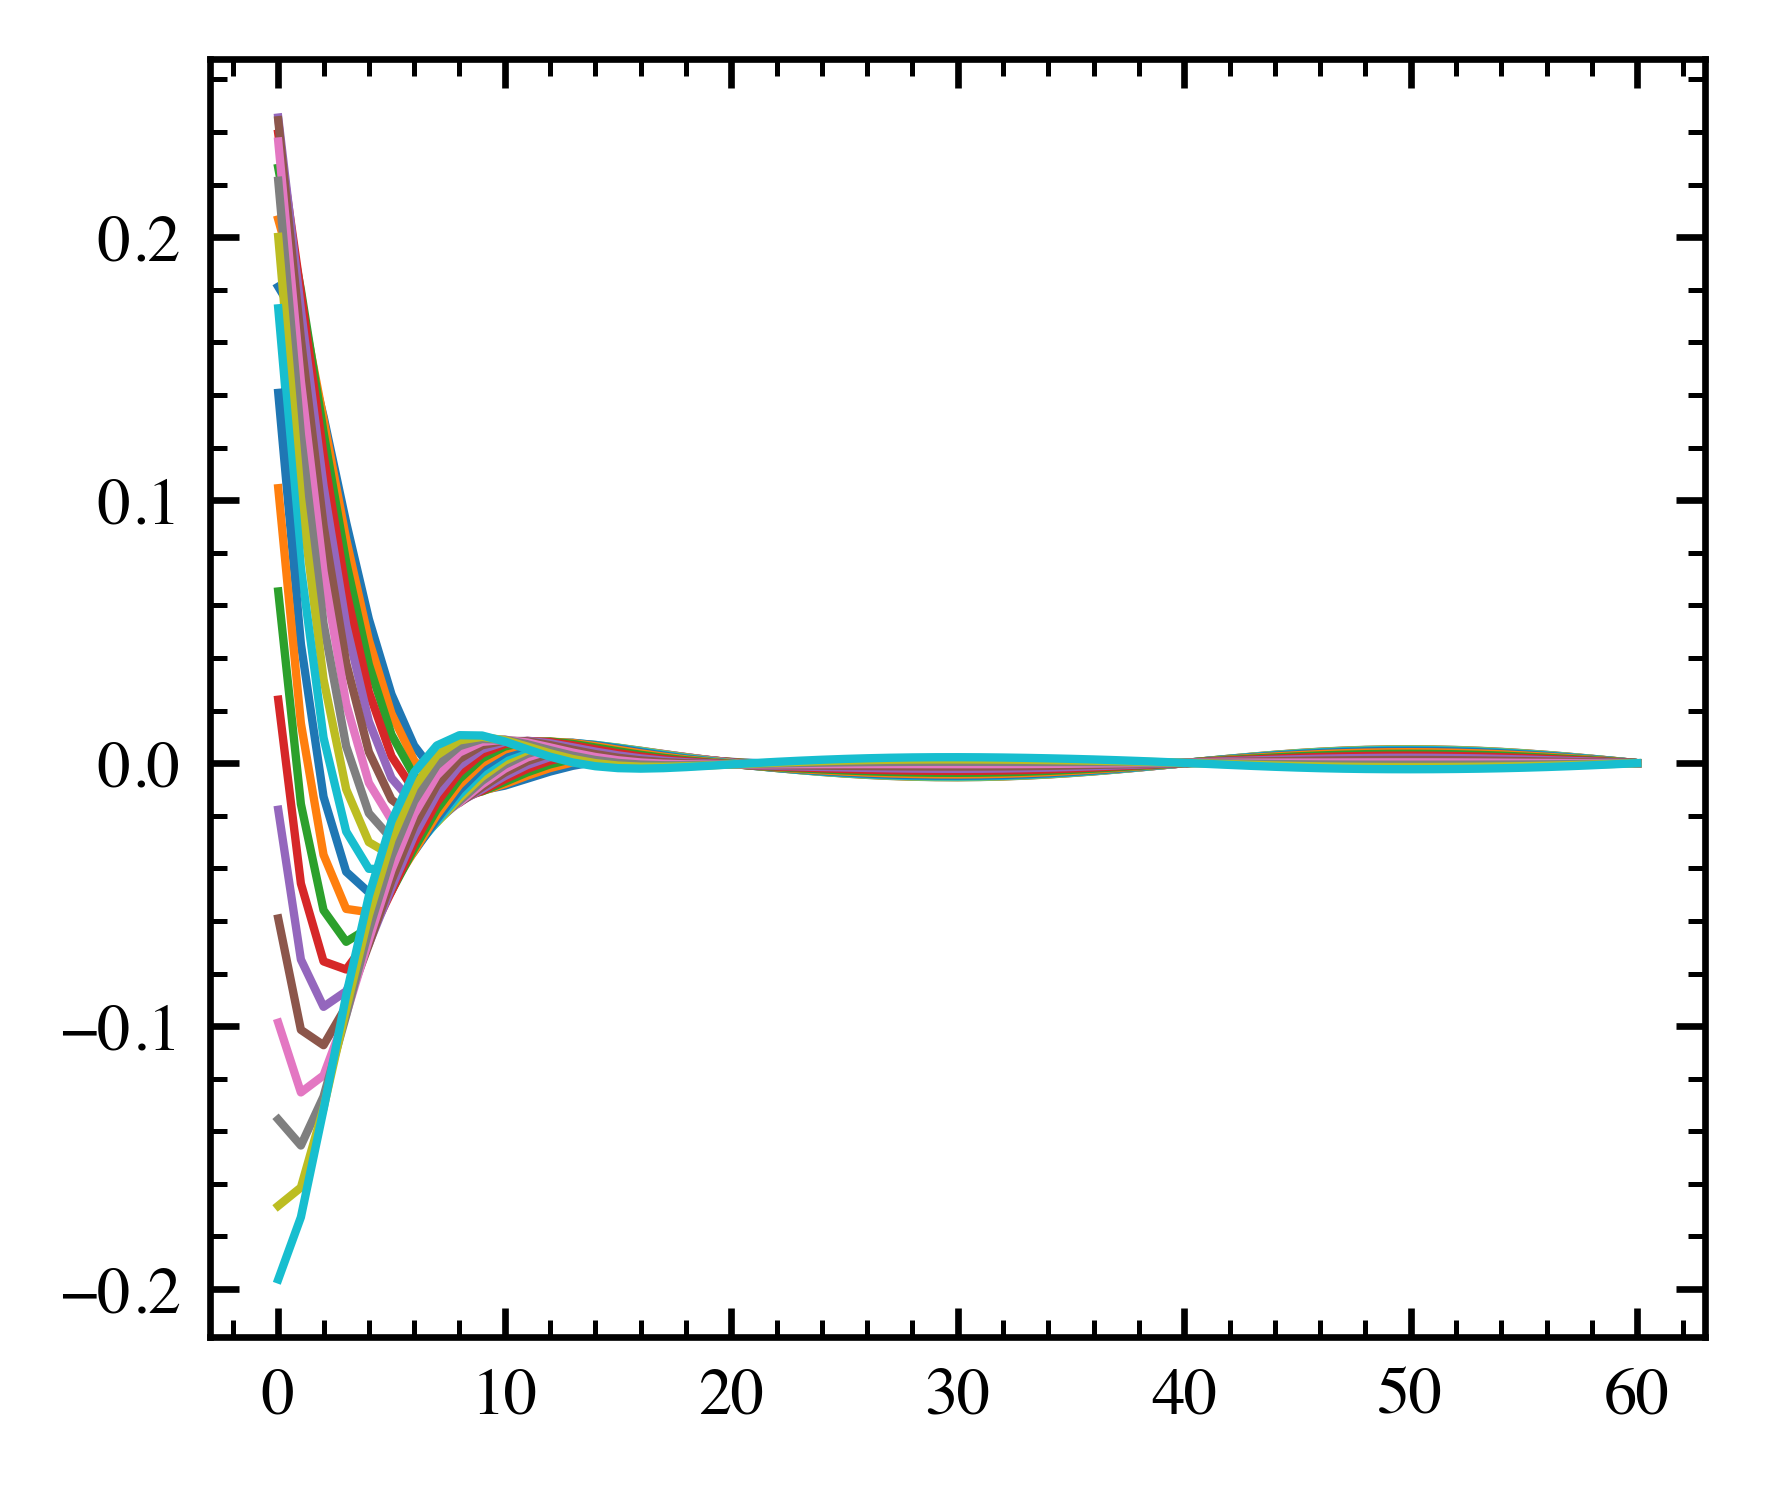

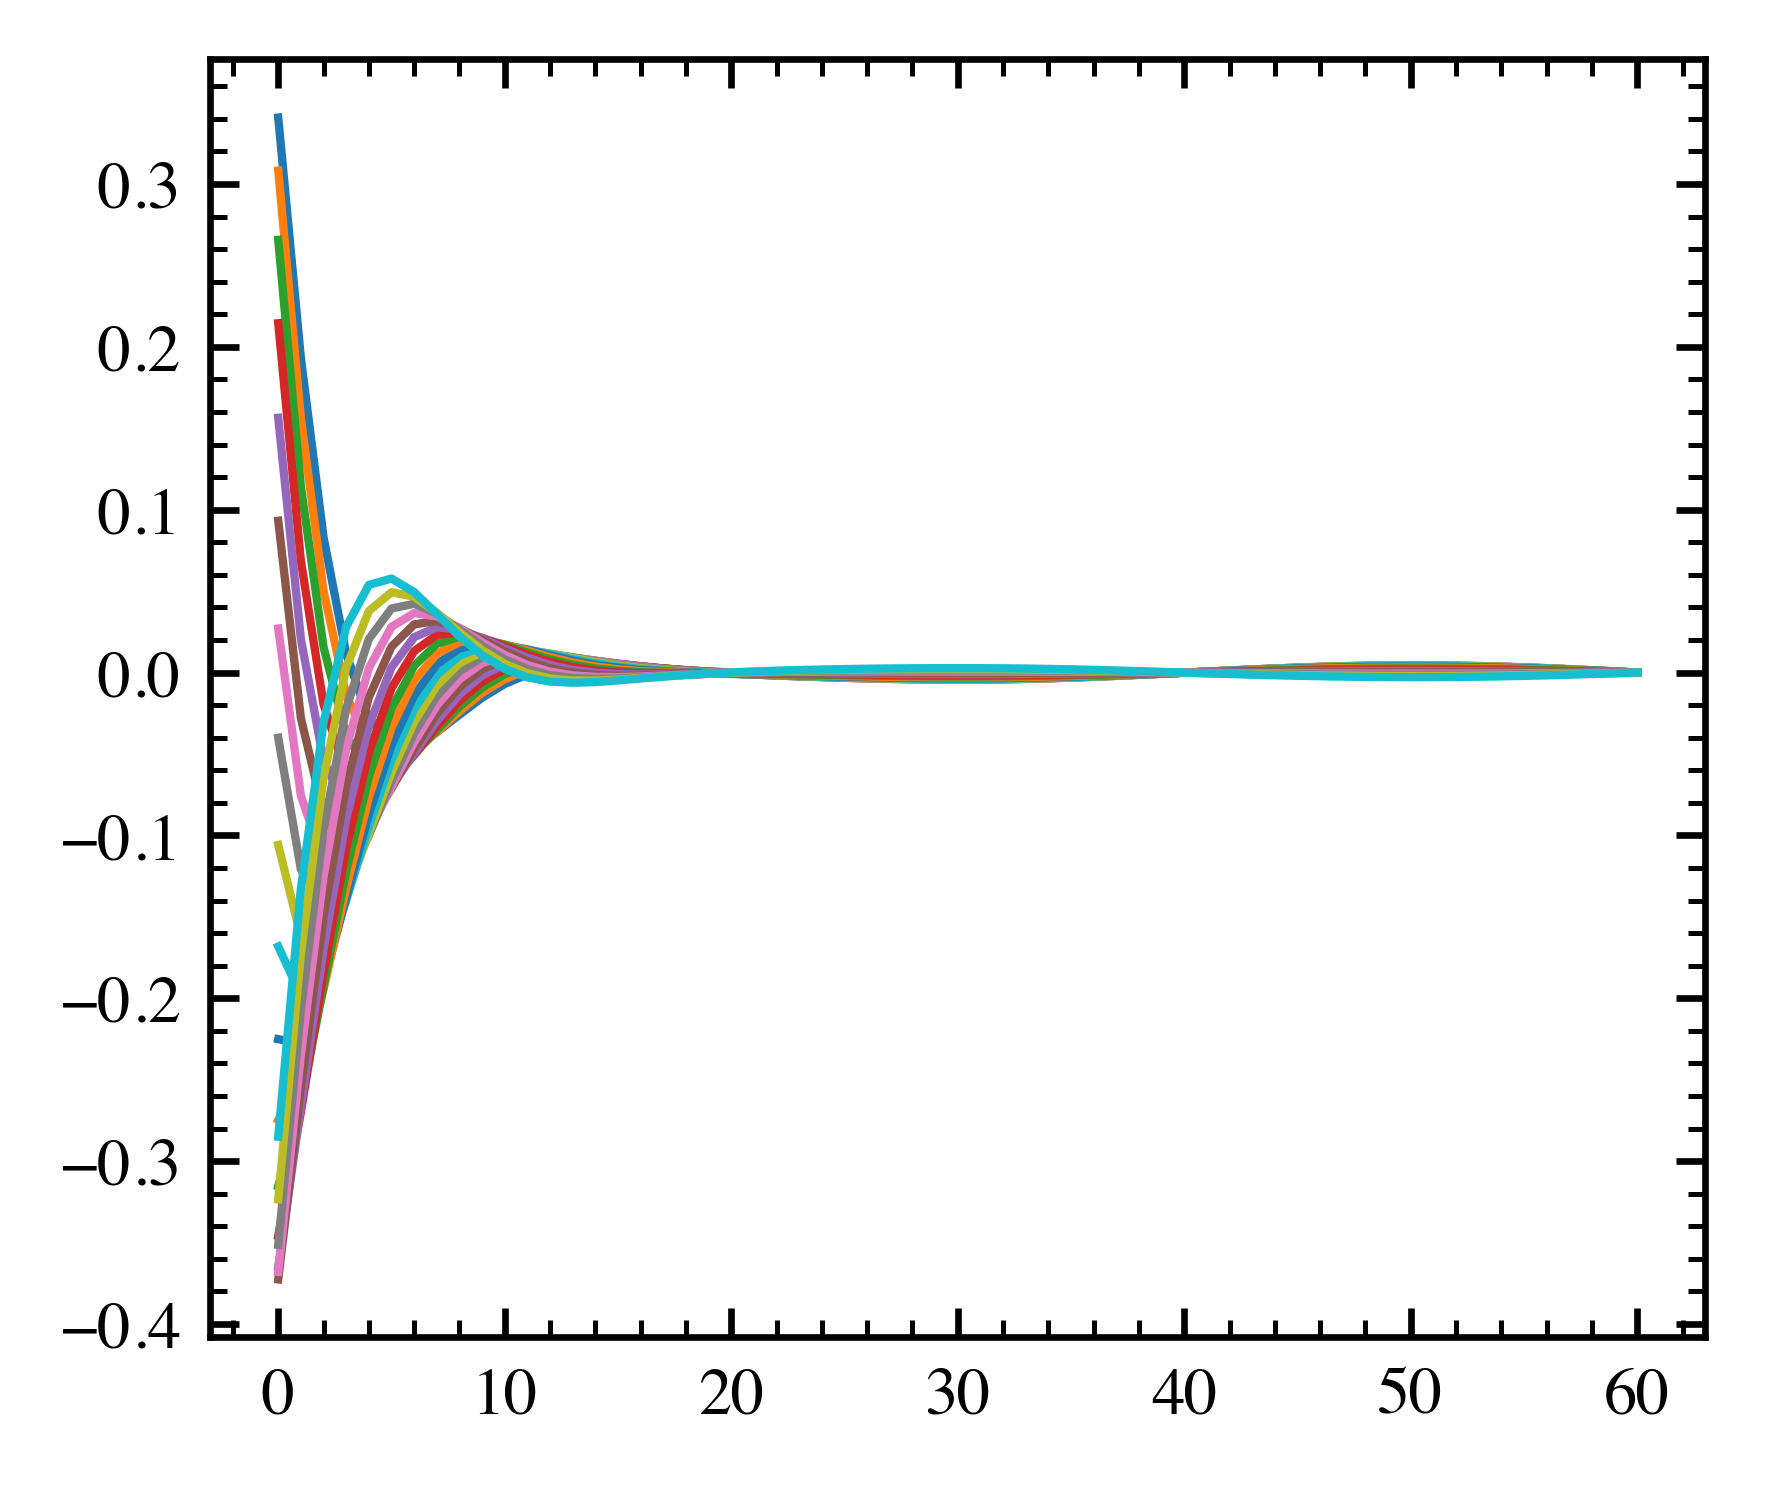

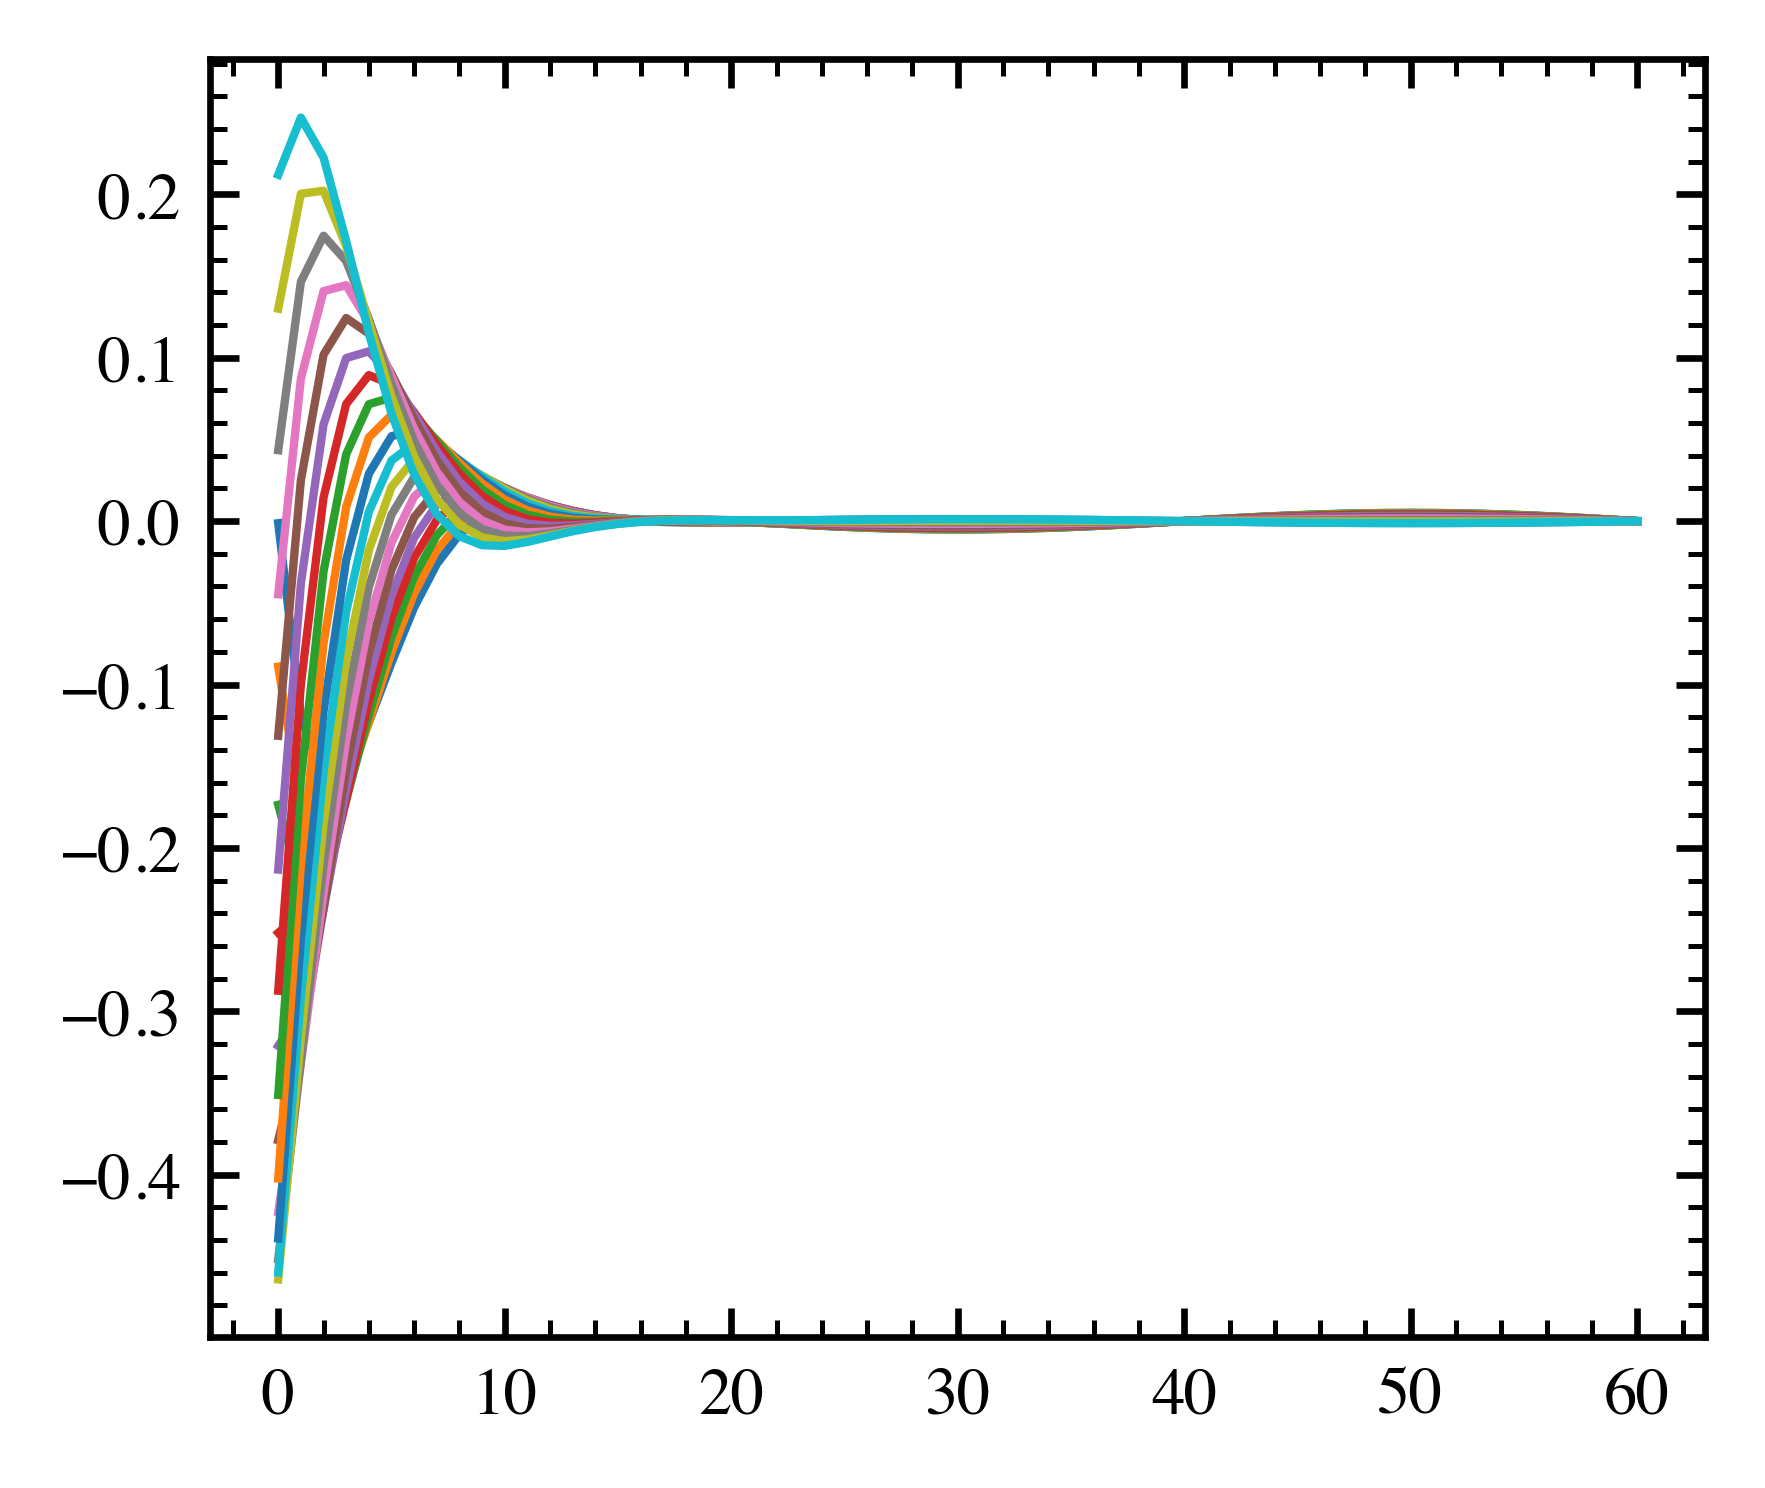

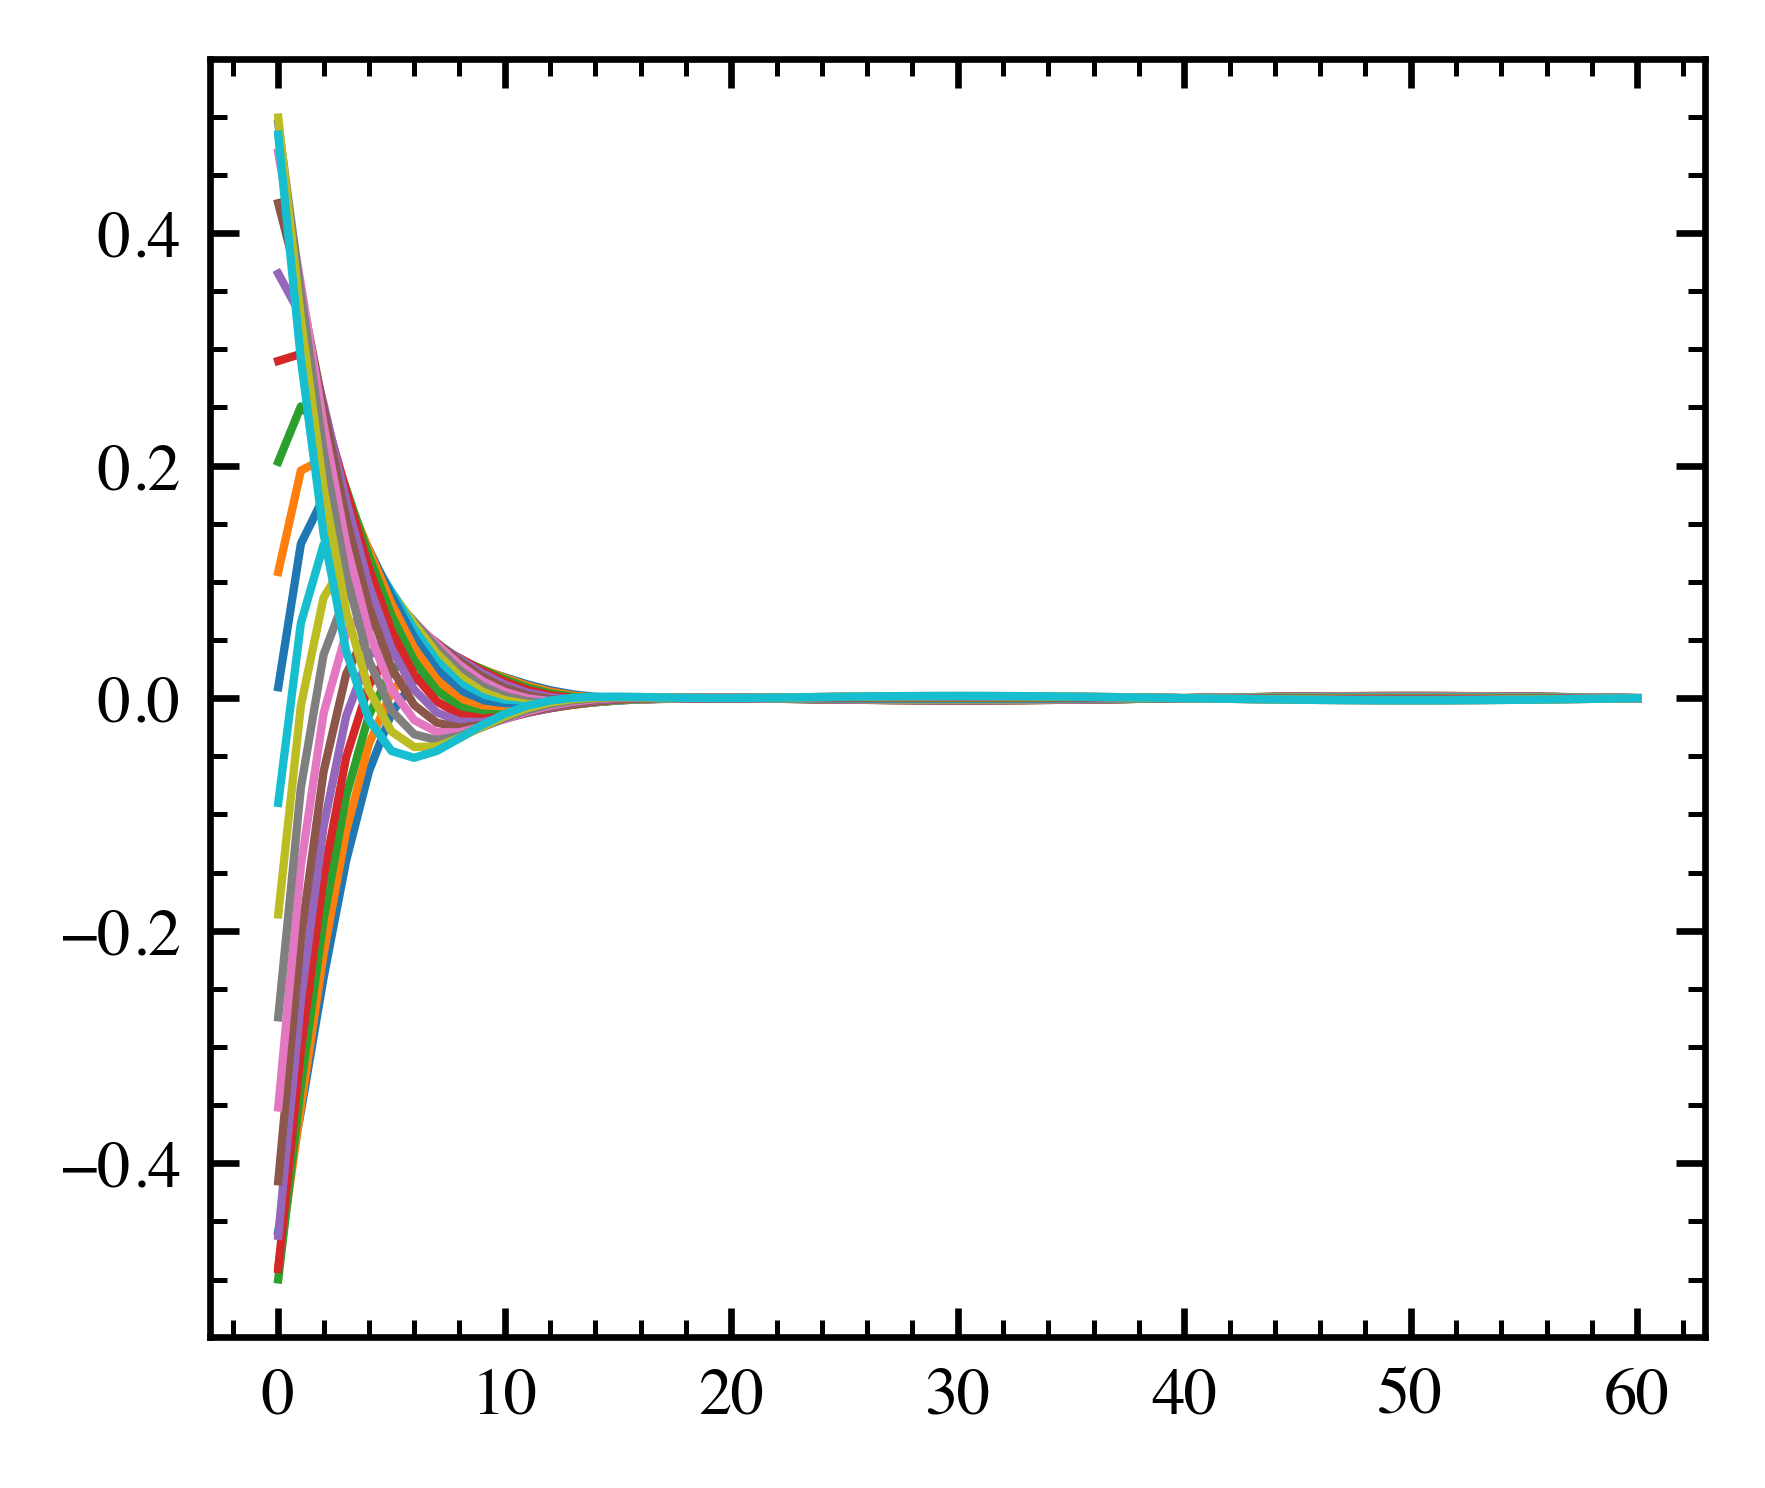

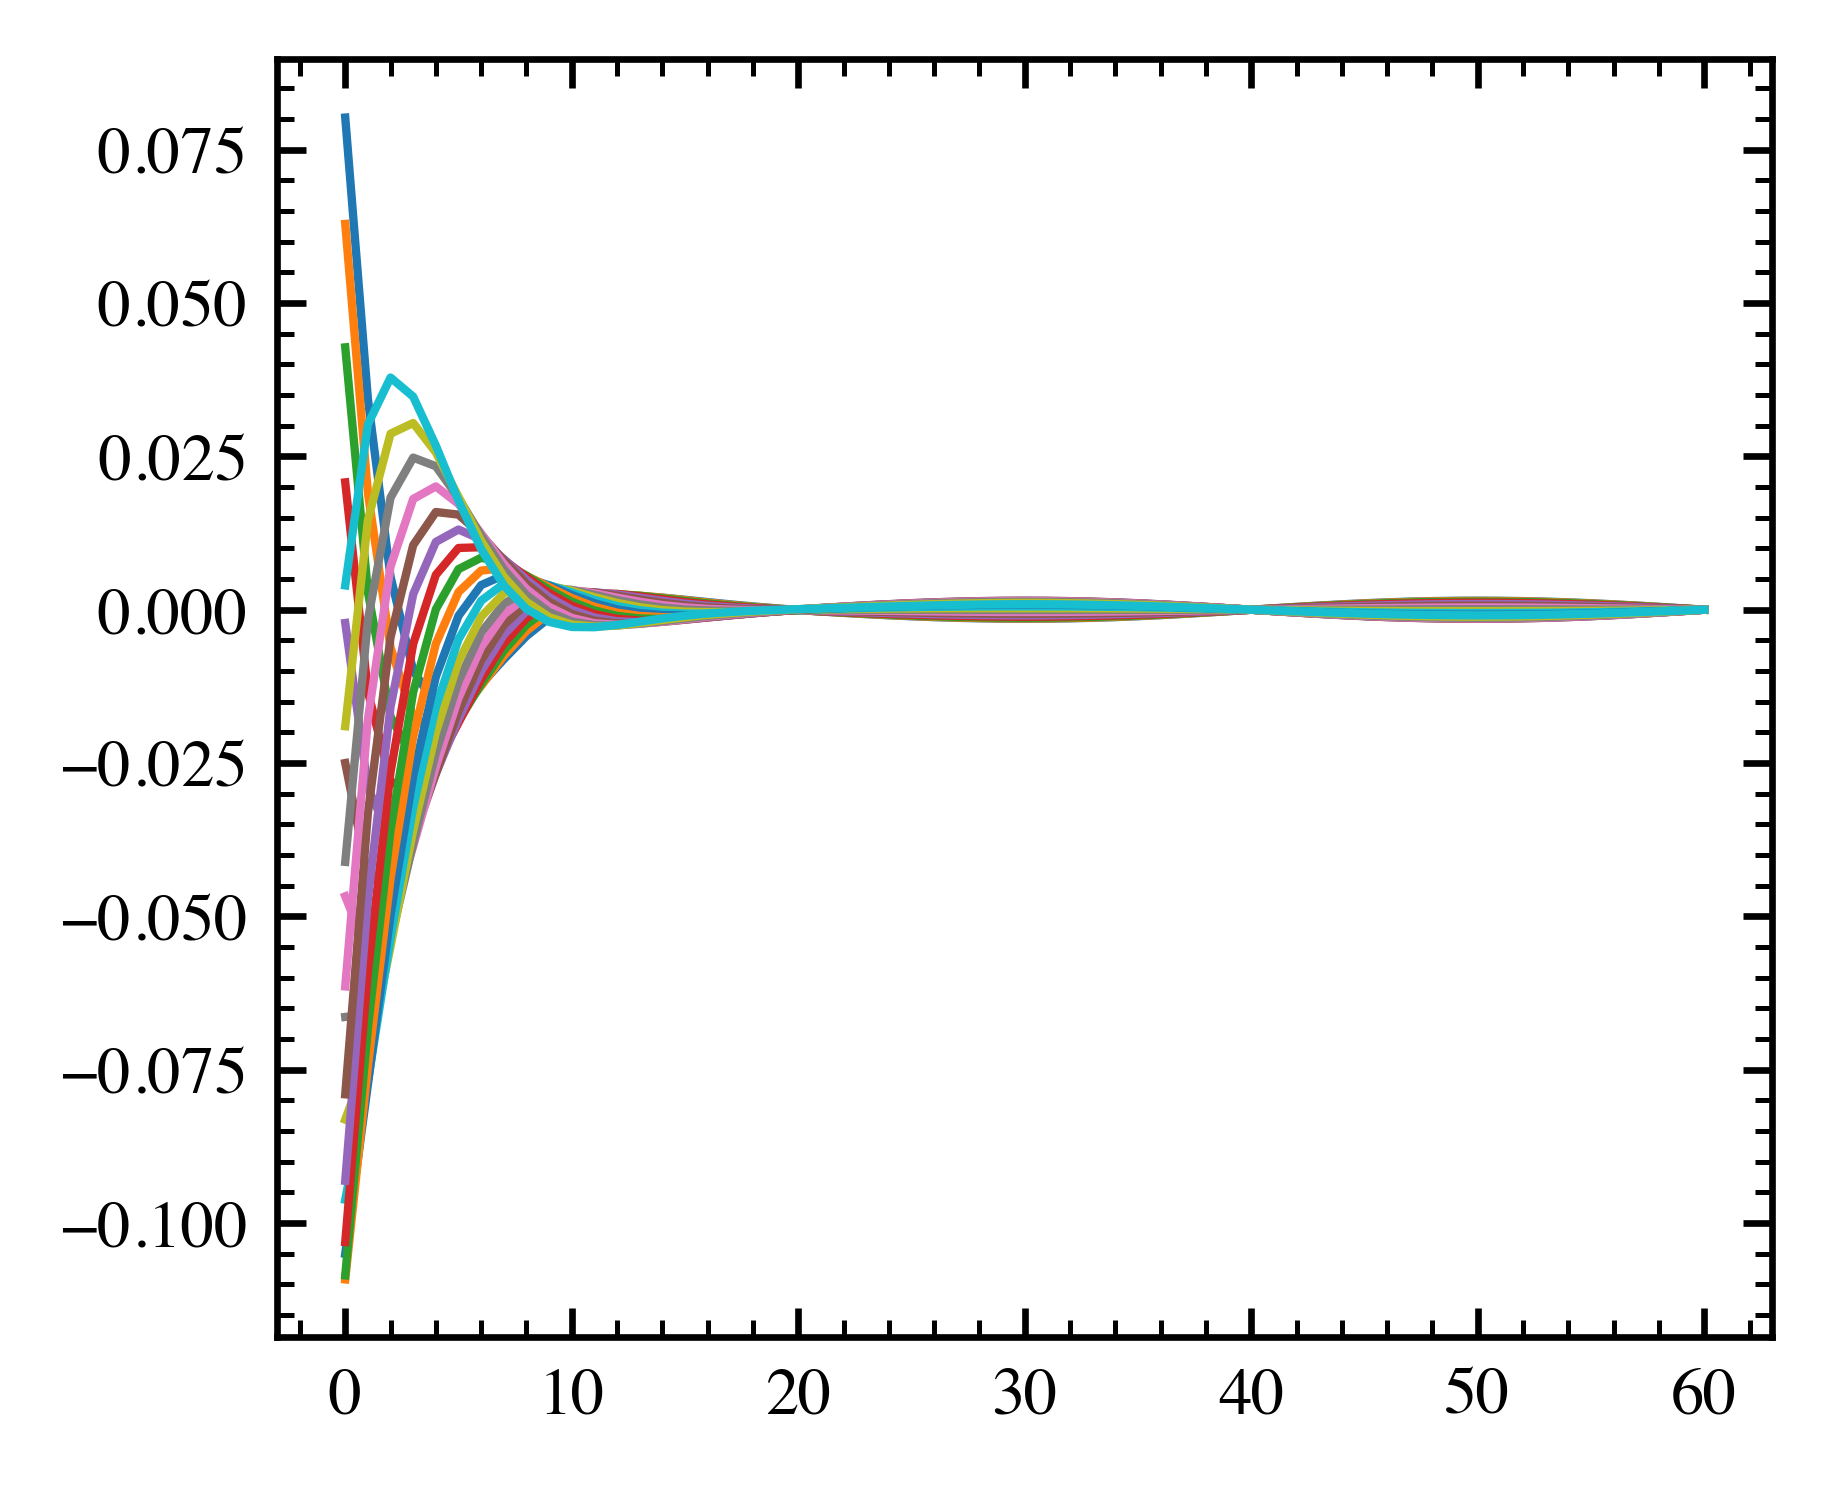

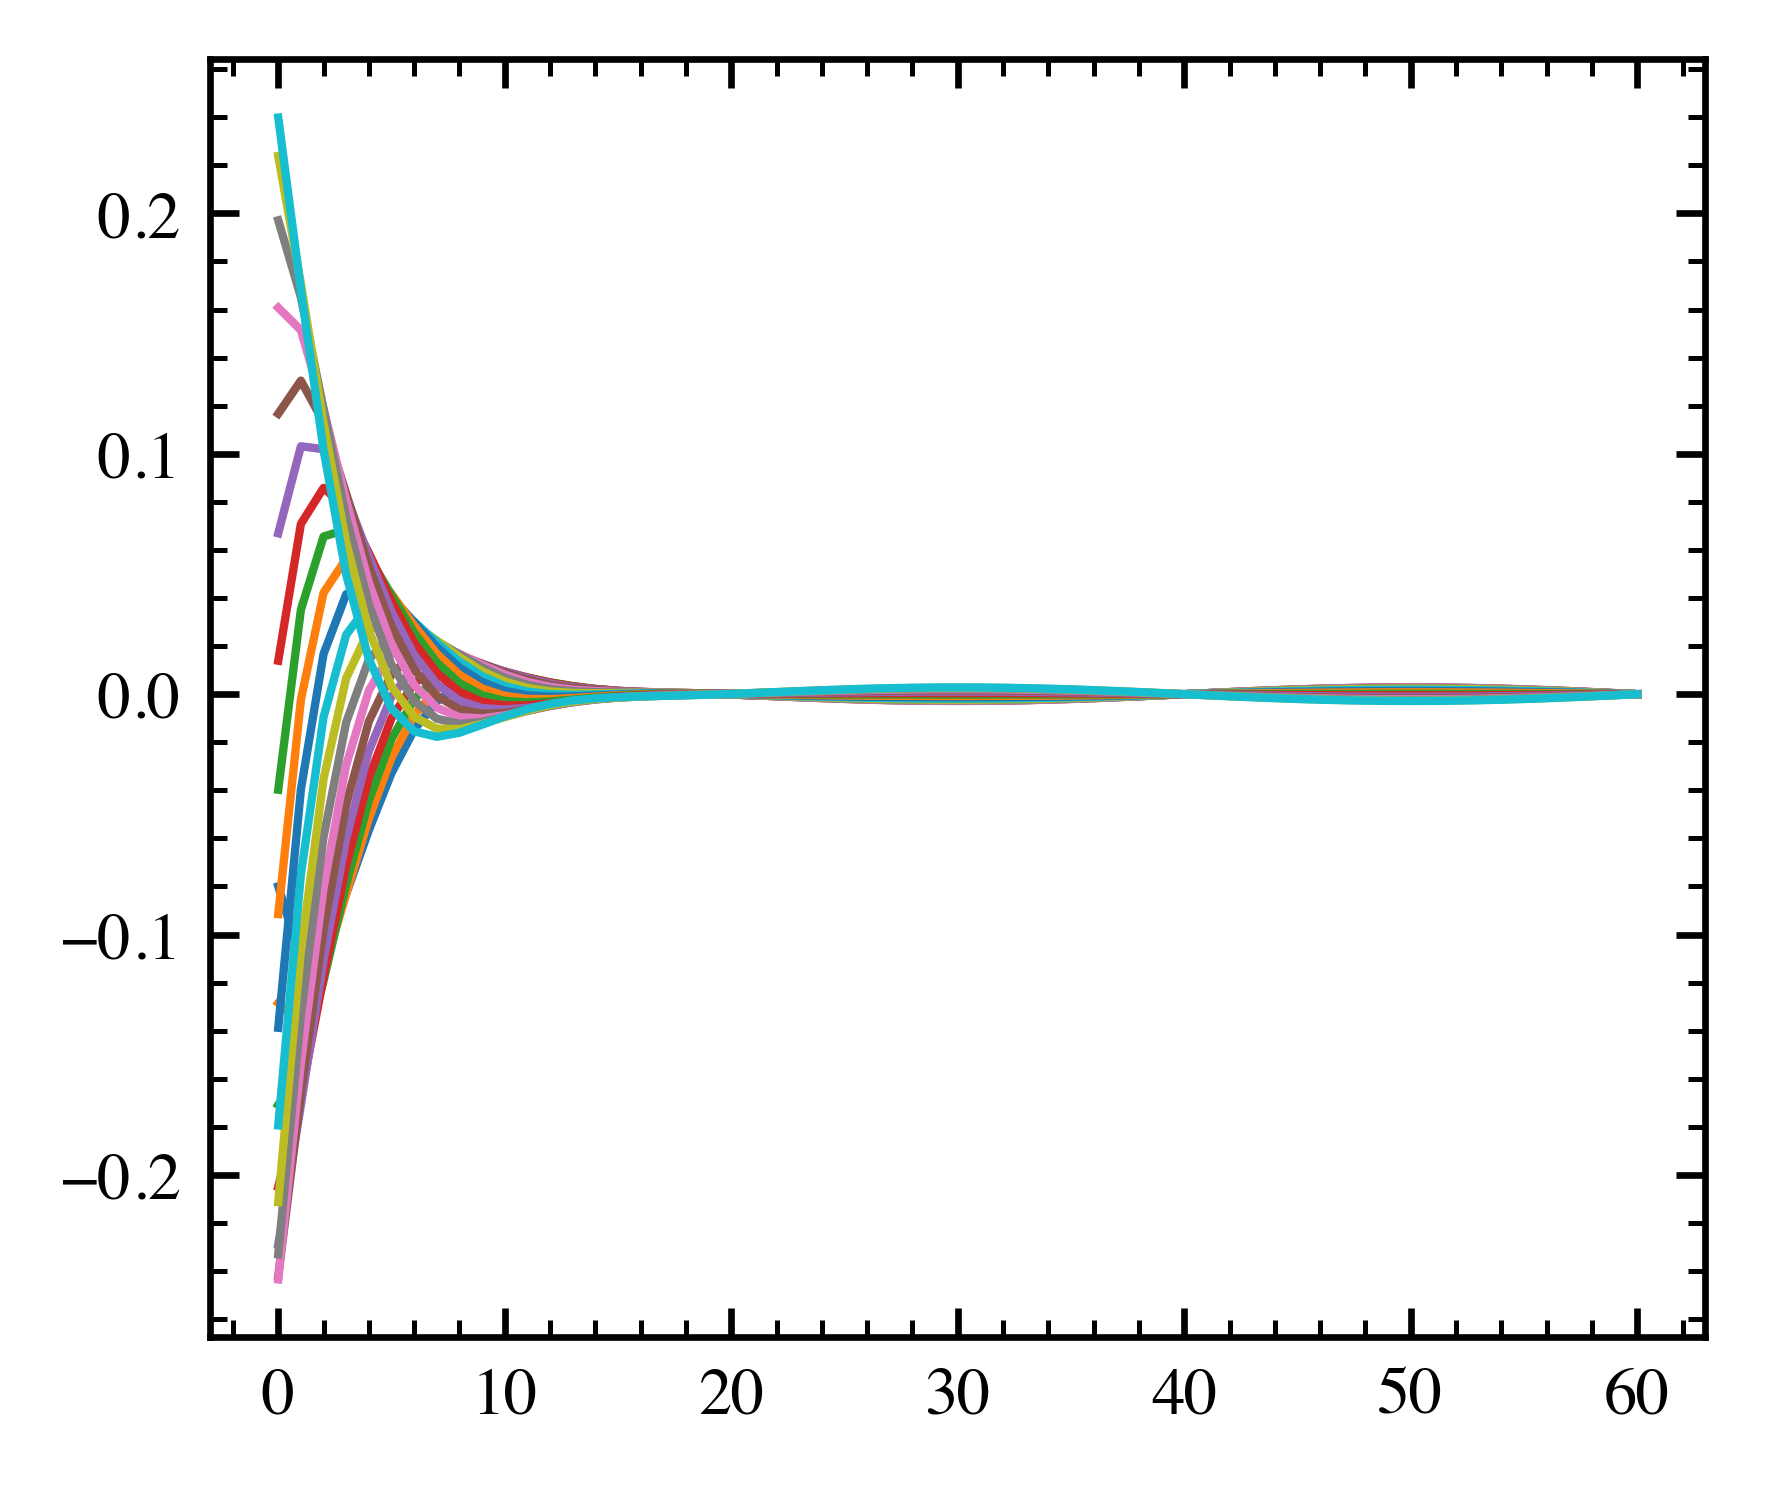

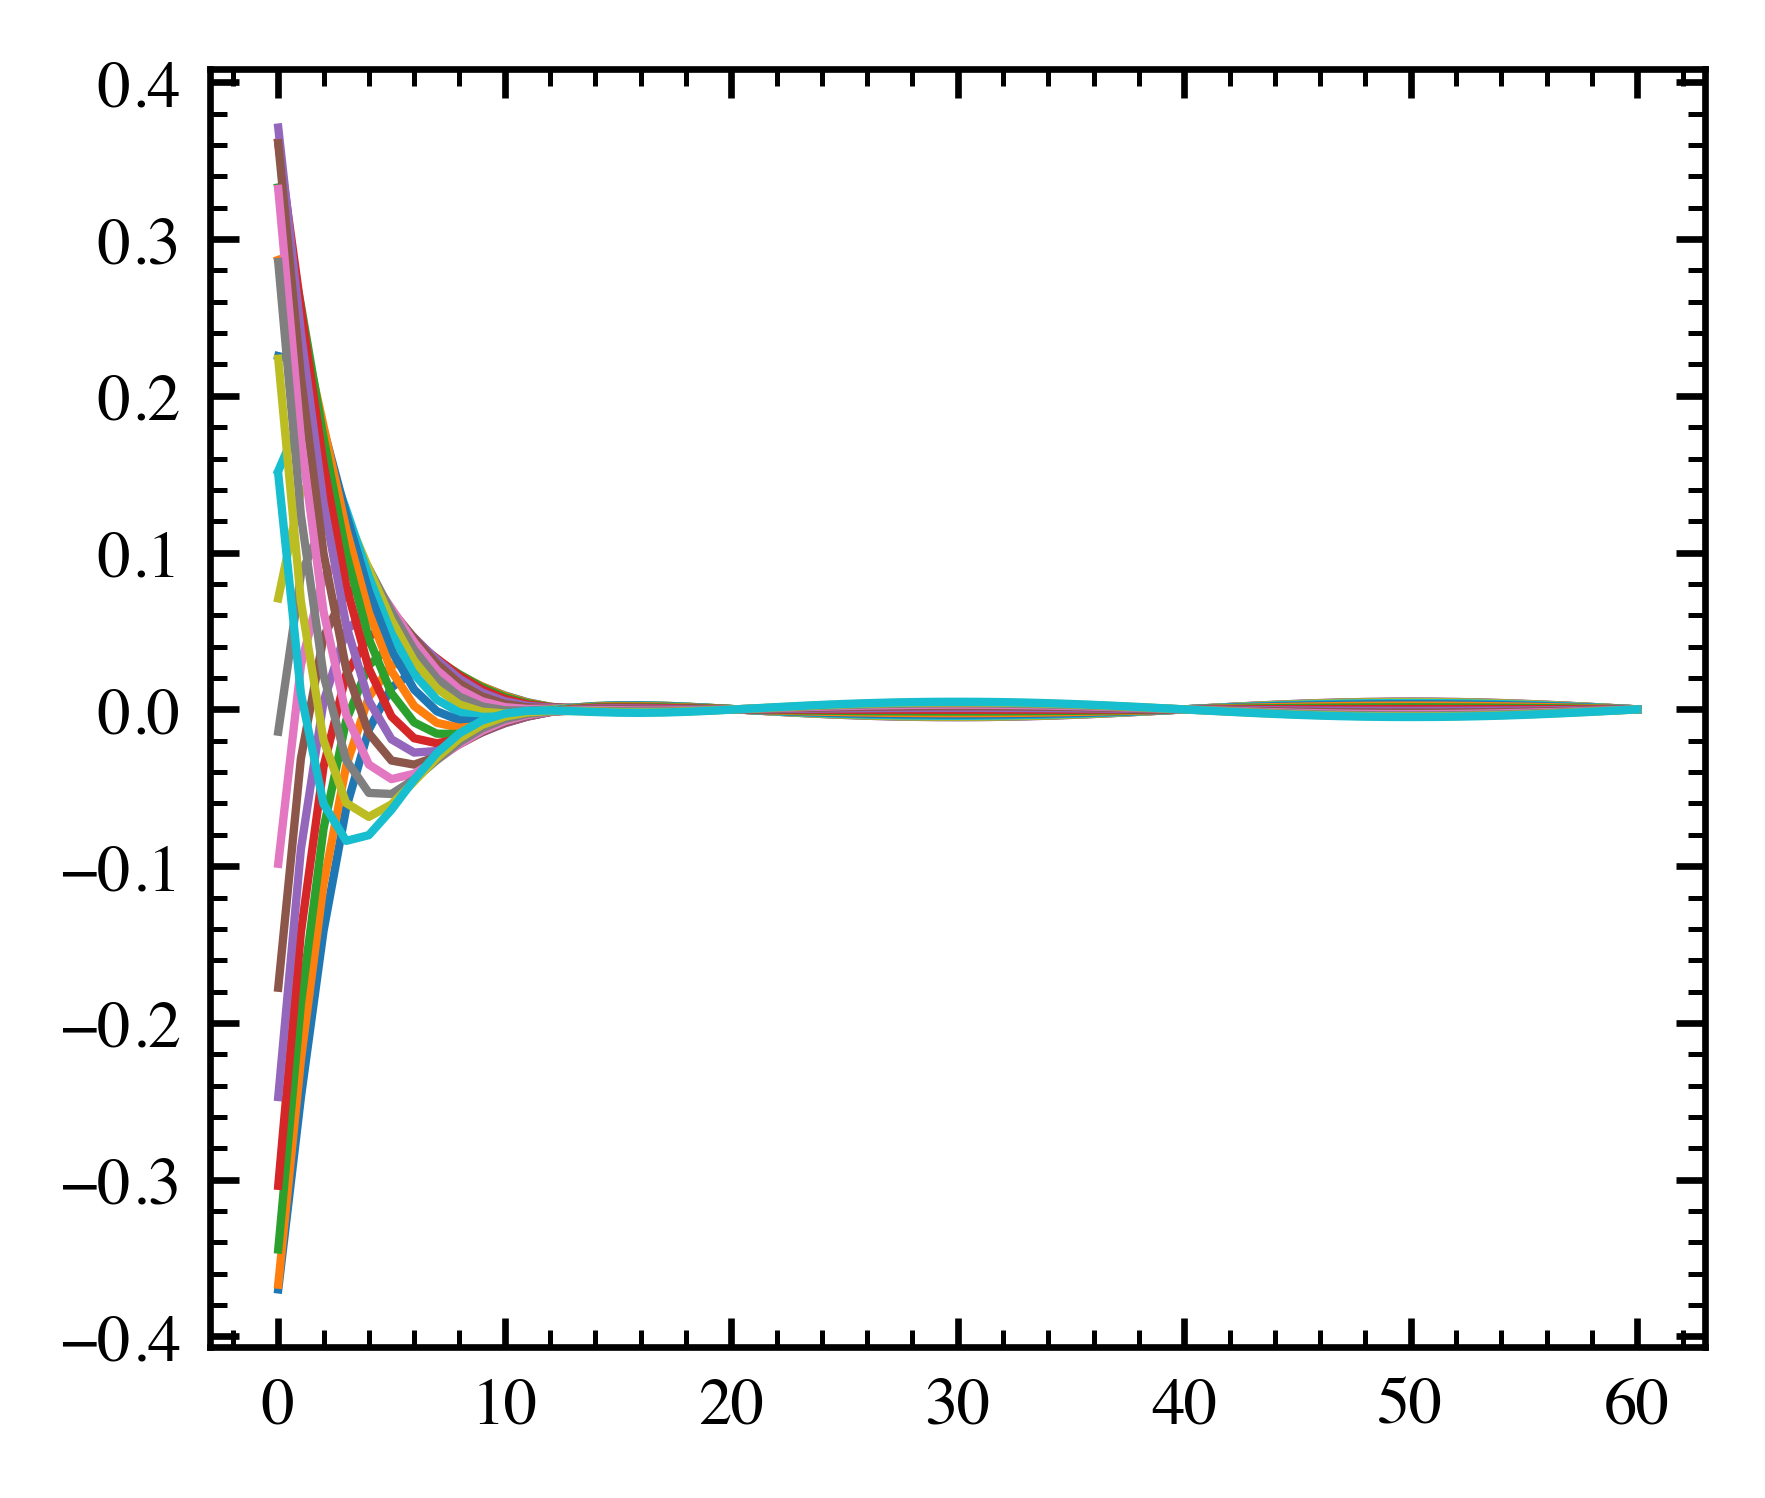

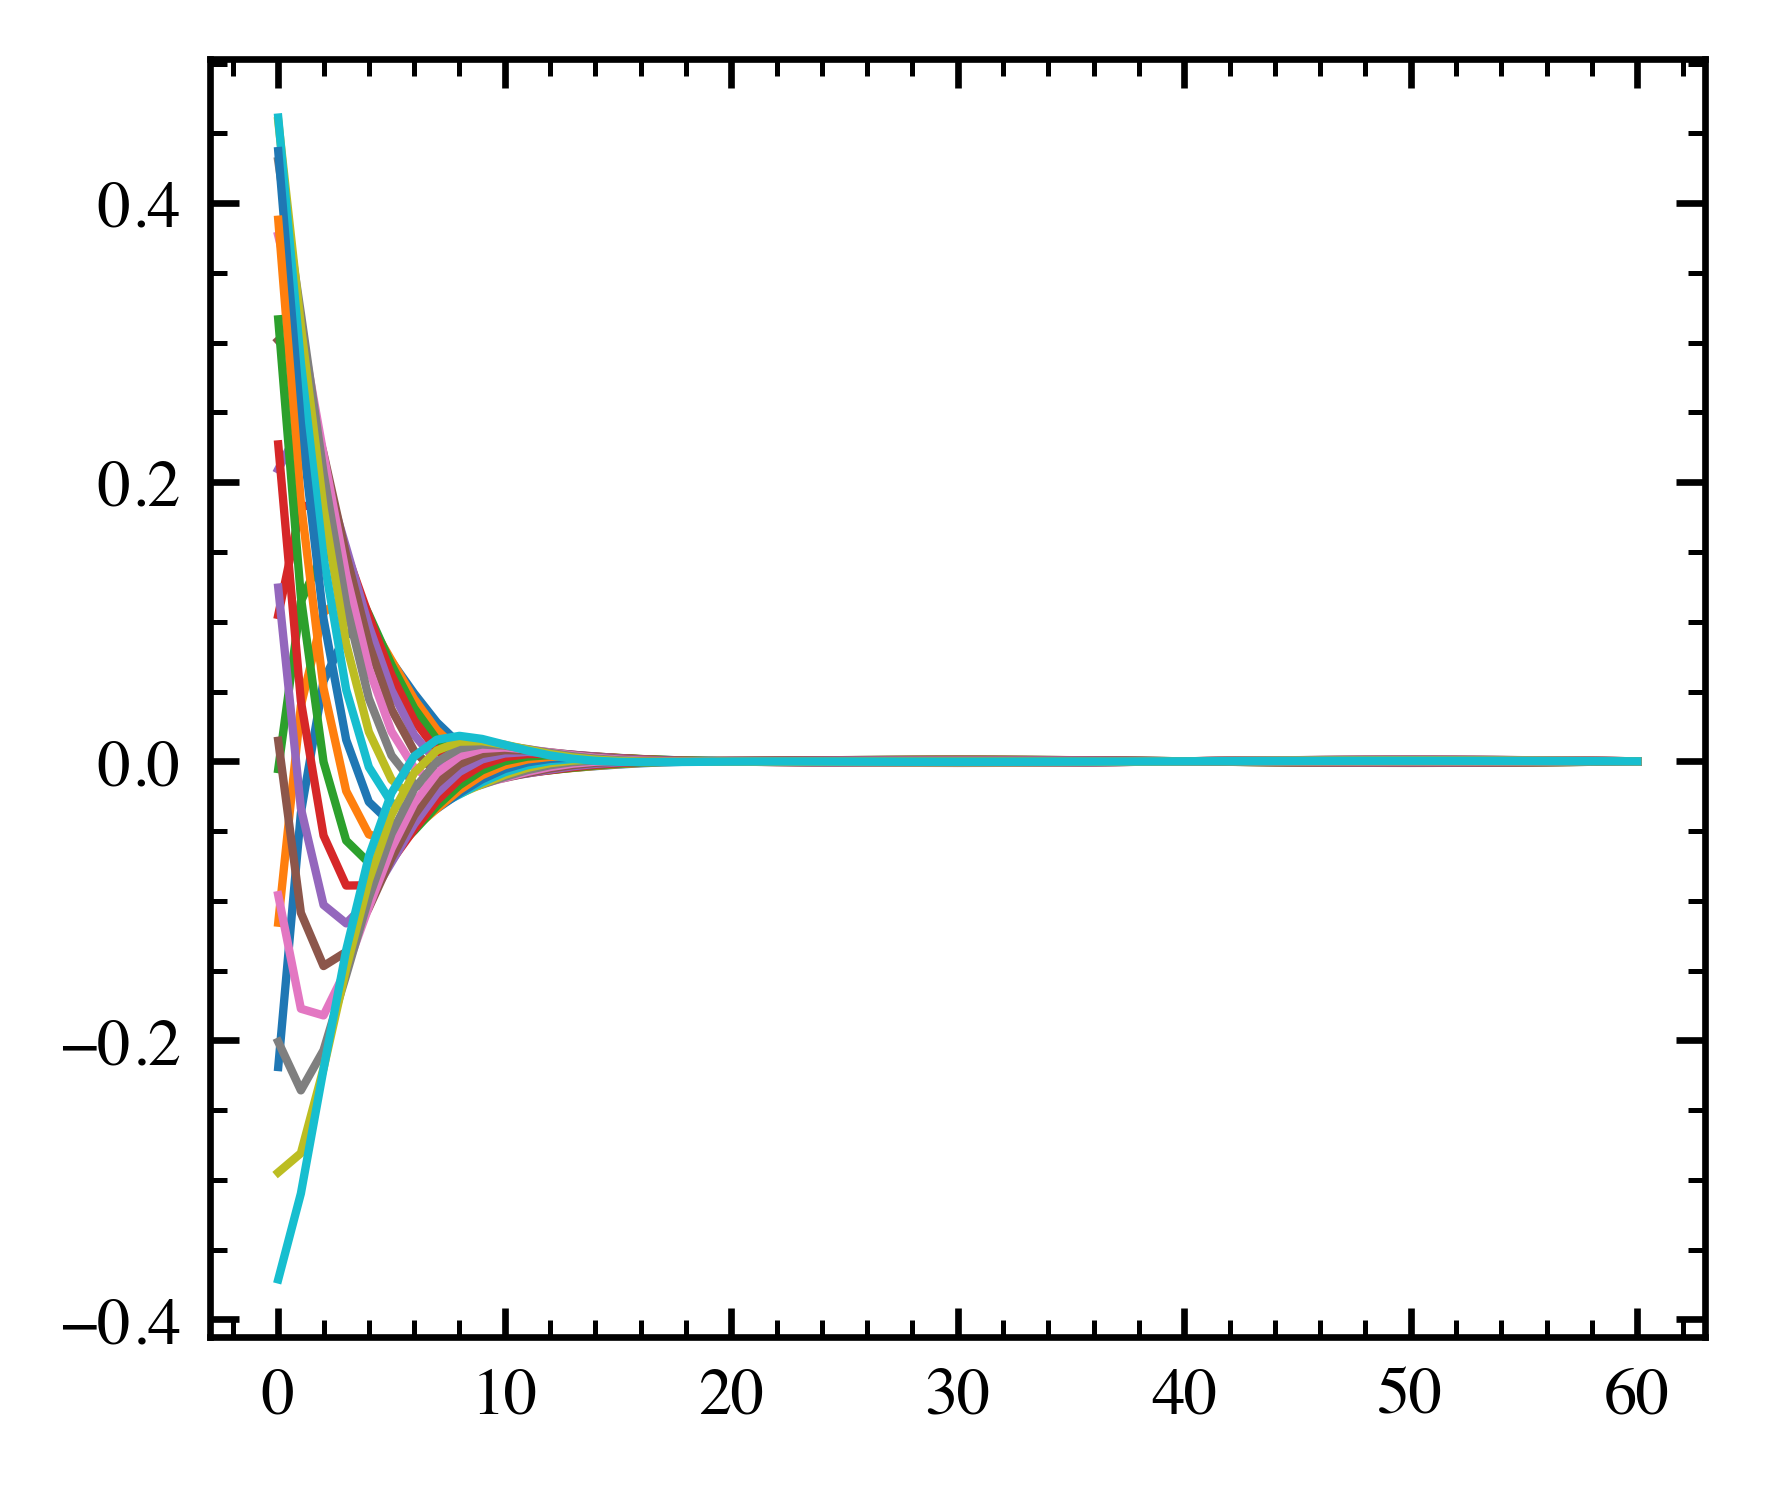

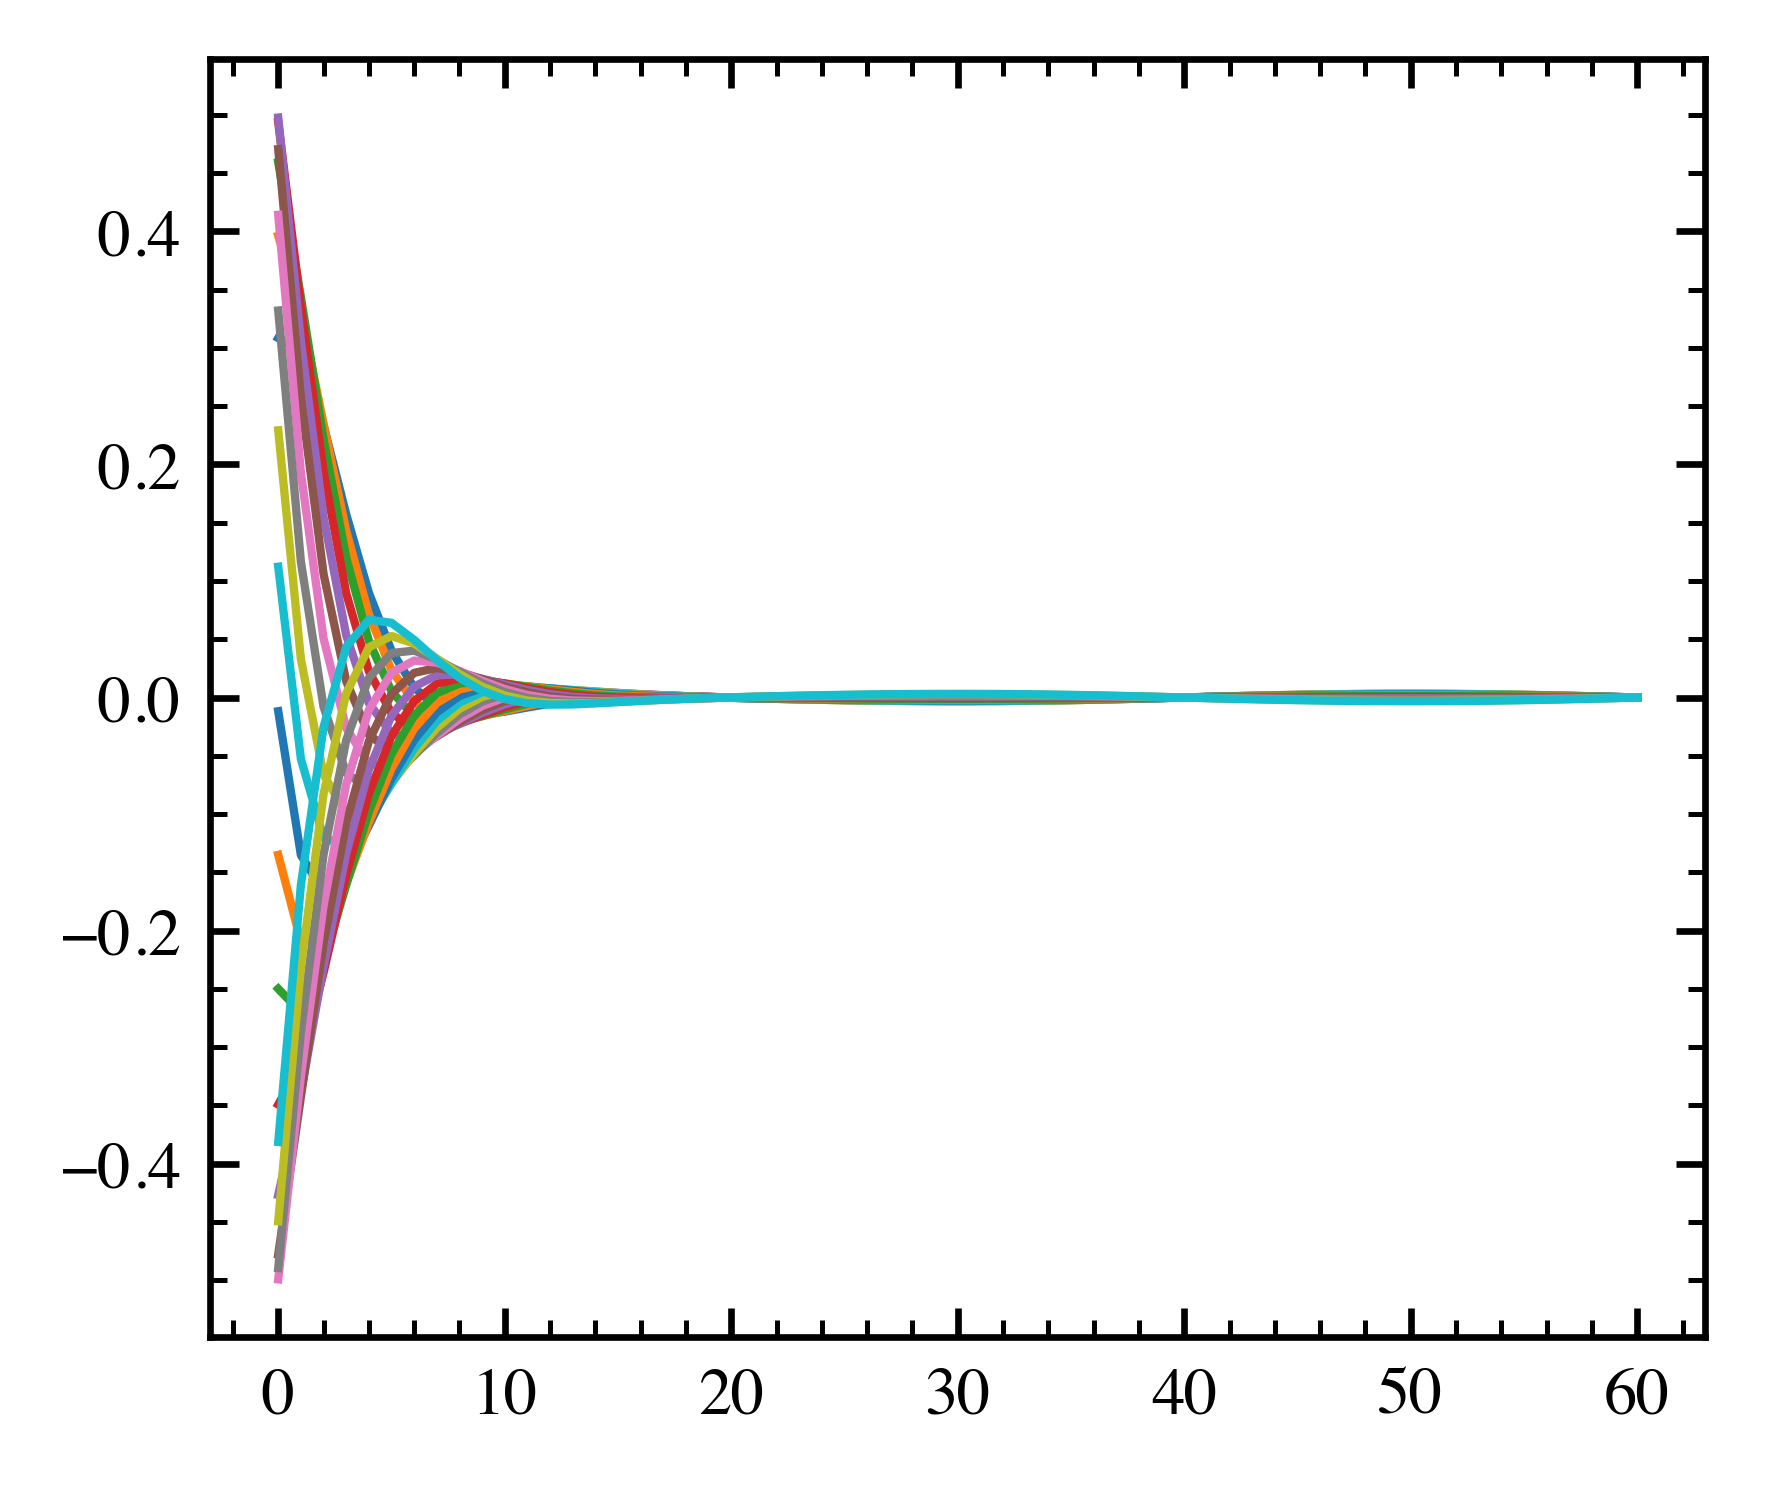

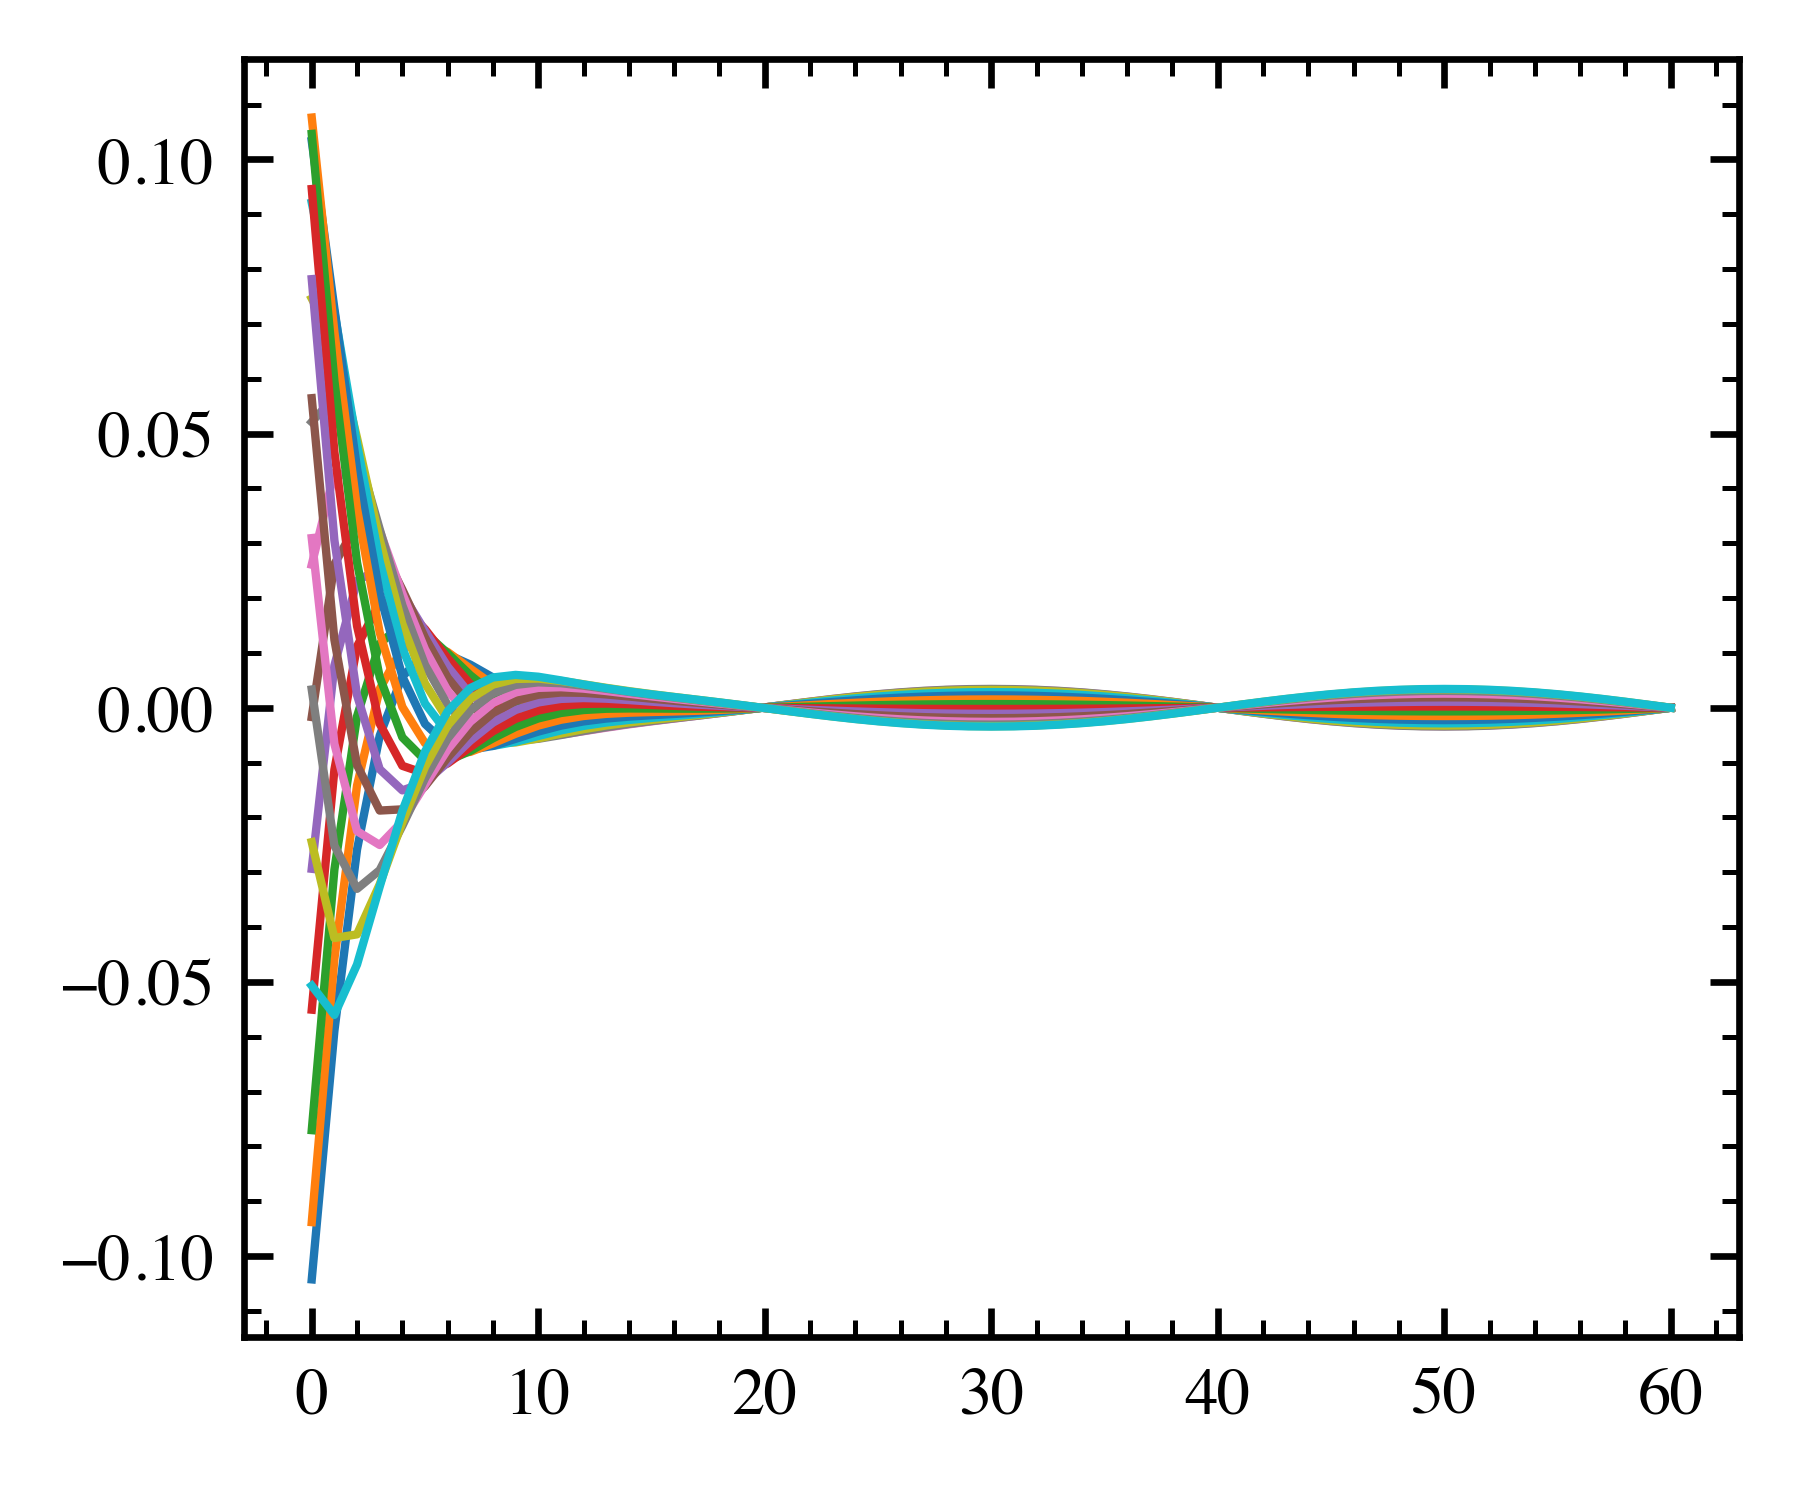

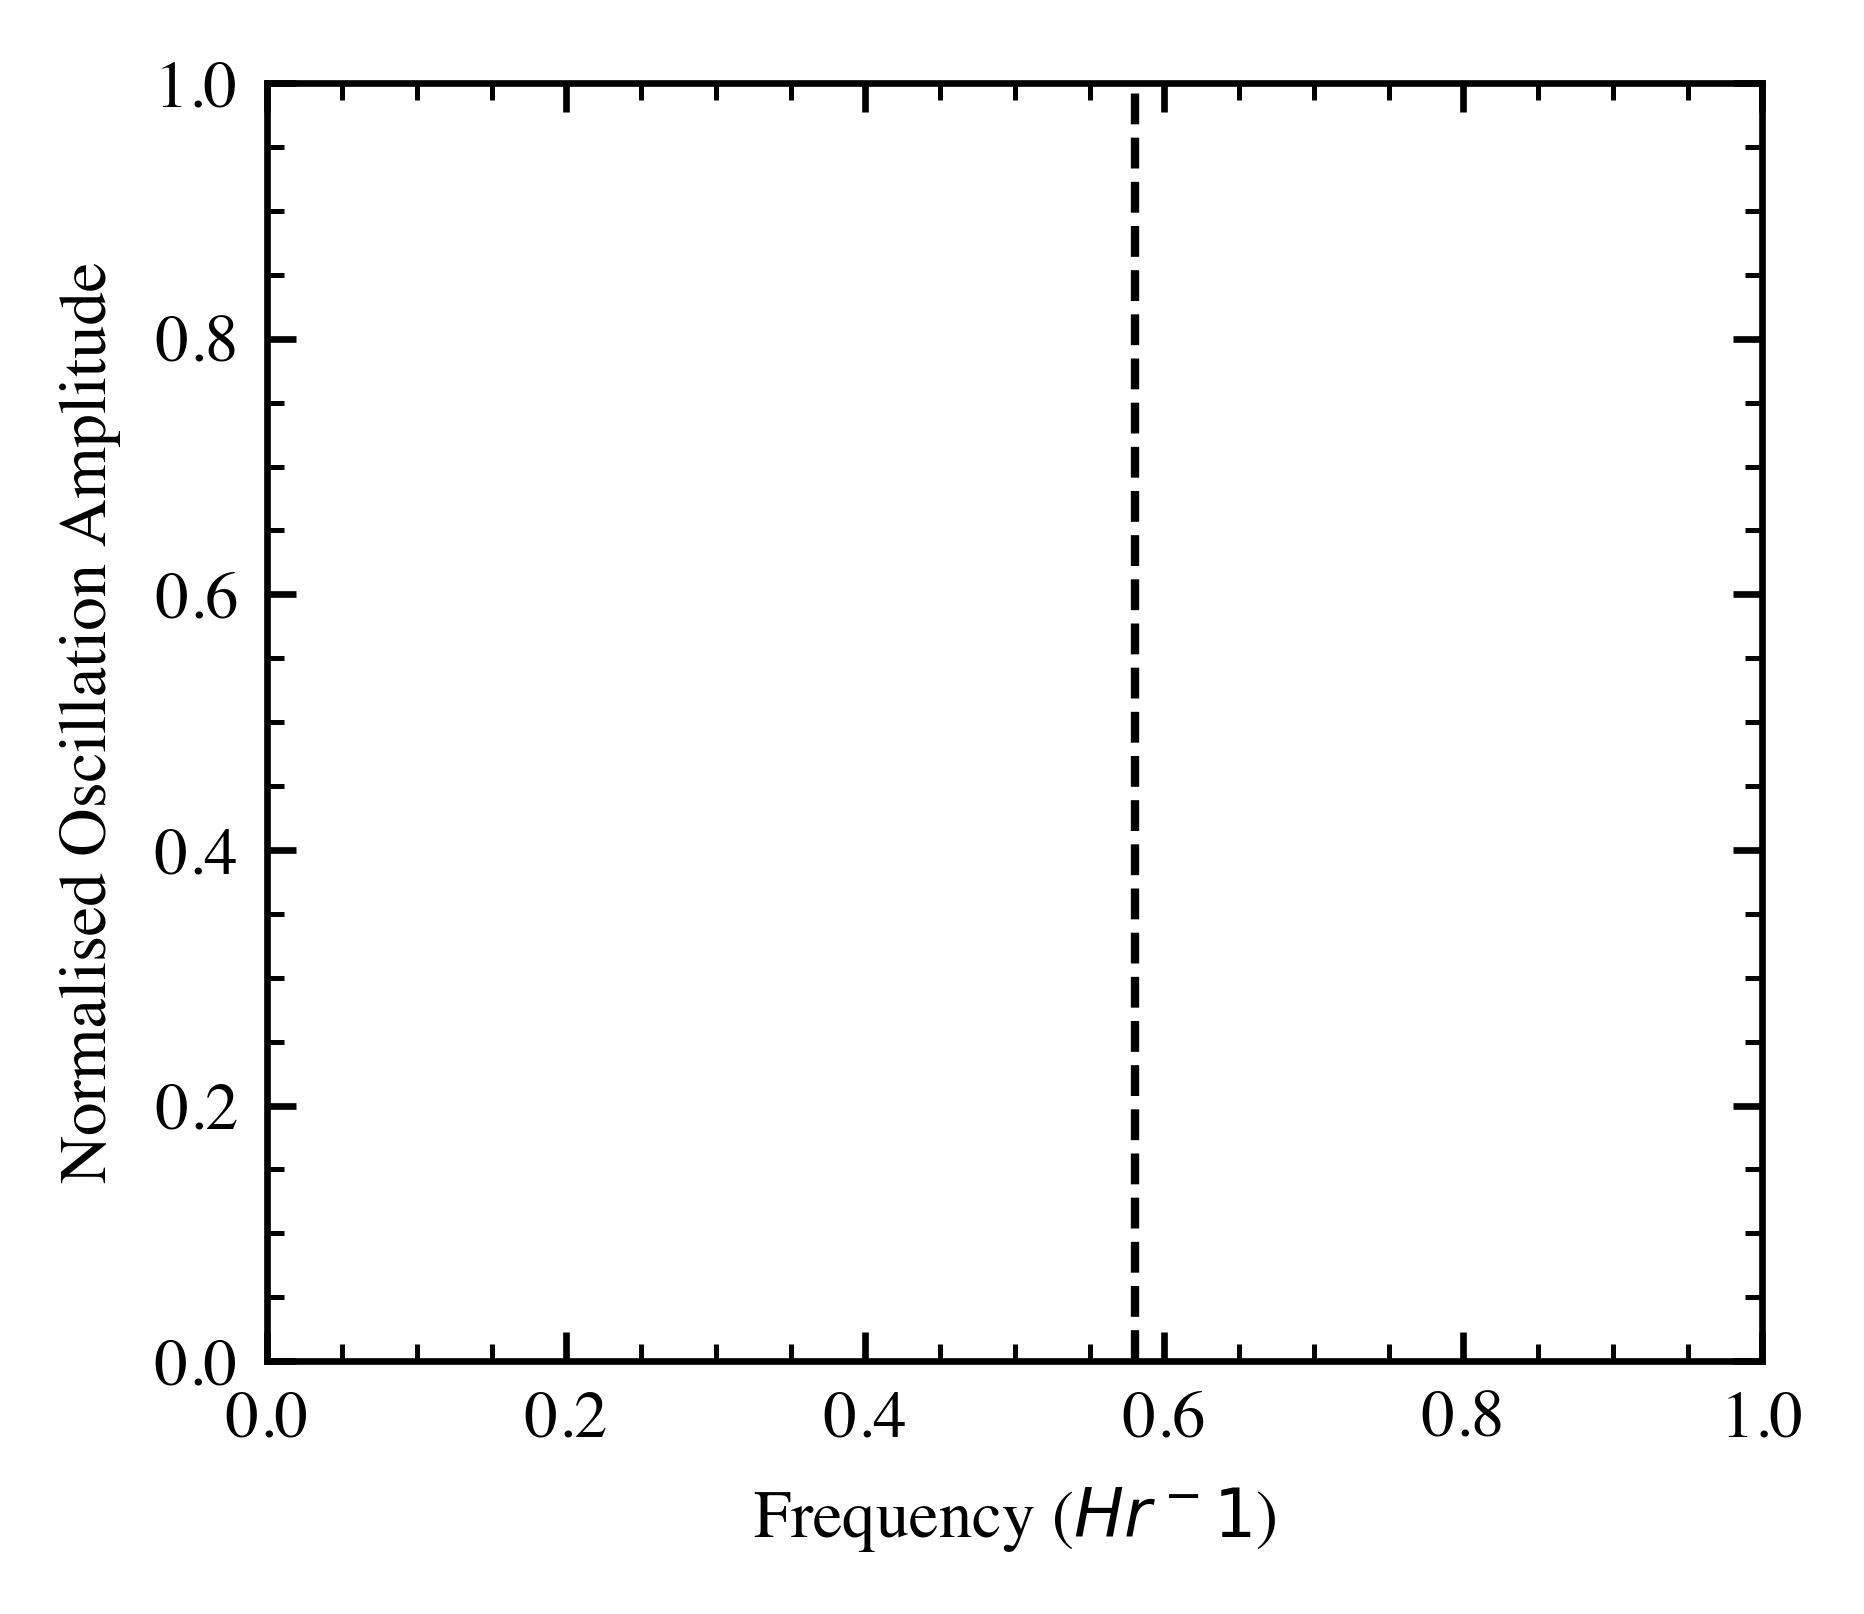

In [91]:
n=3
for i in np.arange(len(omega0s)):
    plt.plot(np.arange(0, Ni[n]+1, 1), Bufields[n][i,-1:-200:-10].T)# , marker='o', color='red')
    plt.show()
plt.axvline(x=0.58, linestyle='dashed', color='black')
plt.xlabel(r'Frequency ($Hr^-1$)')
plt.ylabel('Normalised Oscillation Amplitude')
plt.show()